# Experimentación - AGCRN

https://arxiv.org/abs/2007.02842

TODO:
- Adaptar salida test para tener loss por nodos
- Incluir función guardado de resultados + guardar resultados

## 1. Obtención de datos



In [2]:
import torch_geometric
print(torch_geometric.__version__)

2.3.0


In [3]:
import torch
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import networkx as nx
sns.set_palette("coolwarm_r")

import matplotlib.pyplot as plt
import numpy as np


import os, sys

path = os.getcwd()

sys.path.insert(1, "/".join(path.split("/")[0:-1]))

from utils import powergrid

In [ ]:
#folder_path = "/home/TFM/code_dataset2/datos/Natural Oscillation"
folder_path = "/Users/maguado/Documents/UGR/Master/TFM/datos_2/Natural Oscillation"

In [4]:
loader = powergrid.PowerGridDatasetLoader(folder_path, problem="regression")
_,_,_ =loader.process()
limit = 300
#dataset_full = loader.get_dataset( target= 20, intro=300, step=20, limit=limit, one_ts_per_situation=False)

Processing:  row_214
Node:  0  not included, including...
Node:  1  not included, including...
Node:  2  not included, including...
Node:  3  not included, including...
Node:  4  not included, including...
Node:  5  not included, including...
Node:  6  not included, including...
Node:  7  not included, including...
Node:  8  not included, including...
Node:  9  not included, including...
Node:  10  not included, including...
Node:  11  not included, including...
Node:  12  not included, including...
Node:  13  not included, including...
Node:  14  not included, including...
Node:  15  not included, including...
Node:  16  not included, including...
Node:  17  not included, including...
Node:  18  not included, including...
Node:  19  not included, including...
Node:  20  not included, including...
Node:  21  not included, including...
Node:  22  not included, including...
Processing:  row_32
Processing:  row_57
Processing:  row_110
Processing:  row_248
Processing:  row_119
Processing: 

## Funciones auxiliares - entrenamiento

In [4]:
from utils import pygt_loader

try:
    from tqdm import tqdm
except ImportError:
    def tqdm(iterable):
        return iterable
import os
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import AGCRN
from sklearn.metrics import r2_score

from torch.optim.lr_scheduler import ReduceLROnPlateau
from utils.utils_graph import format_plot, plot_training_and_eval_losses, plot_predictions
from utils.general_nn import guardar_resultados


from utils import trainer
dtype = torch.float
device = torch.device("cpu")

In [18]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, n_features, n_nodes, embedding_dim, name, n_target):
        self.name  =name
        self.n_nodes = n_nodes
        self.n_target = n_target
        self.n_features = n_features
        self.embedding_dim =embedding_dim
        super(RecurrentGCN, self).__init__()

        self.recurrent = AGCRN(number_of_nodes = n_nodes,
                              in_channels = n_features,
                              out_channels = n_nodes,
                              K = 2,
                              embedding_dimensions = embedding_dim)
        self.linear = torch.nn.Linear(n_nodes,n_target)



    def forward(self, x, e, h):
        h_0 = self.recurrent(x, e, h)
        y = F.relu(h_0)
        y = self.linear(y)
        return y, h_0


In [19]:
def eval(model, dataloader, e, h):
    model.eval()
    e_loss_batch, r2_loss_batch = [], []
    
    for batch in dataloader['val']:
        batch = batch.to(device)
        x = batch.x.view(len(batch), model.n_nodes, model.n_features)
        y_hat, h = model(x, e, h)
        loss = F.mse_loss(y_hat.view(-1, model.n_target), batch.y).item()
        r2_loss_batch.append(r2_score(batch.y.cpu(), y_hat.view(-1, model.n_target).cpu()))
        e_loss_batch.append(loss)
    return e_loss_batch, r2_loss_batch



def train(model,dataloader, num_early_stop, num_epochs, lr ):

    print("\n==================== TRAIN INFO ===================\n")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.to(device)
    lr_schedule = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, min_lr=0.001)
    early_stop_counter = 0
    best_eval_loss = float('inf')
    losses = []
    eval_losses, r2scores = [], []

    e = torch.empty(model.n_nodes, model.embedding_dim)
    torch.nn.init.xavier_uniform_(e)
    i = 0

    for epoch in range(num_epochs):
        h = None
        losses_batch = []
        model.train()
        
        for batch in dataloader['train']:
            x = batch.x.view(len(batch), model.n_nodes, model.n_features)
            y_hat, h = model(x, e, h)
            loss = F.mse_loss(y_hat.view(-1, model.n_target), batch.y)
            loss.backward(retain_graph=False)
            loss = loss.detach()
            h = h.detach()
            losses_batch.append(loss.item())
            optimizer.step()
            optimizer.zero_grad()
            i += 1
            
        train_loss = torch.FloatTensor(losses_batch).mean().item()
        losses.append(losses_batch)
    
        with torch.no_grad():
            e_loss_batch, r2_loss_batch = eval(model, dataloader, e, h)
            eval_loss = torch.FloatTensor(e_loss_batch).mean().item()
            eval_r2score = torch.FloatTensor(r2_loss_batch).mean().item()
            eval_losses.append(e_loss_batch)
            r2scores.append(r2_loss_batch)
        
        print(f"Epoch {epoch + 1}/{num_epochs} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Eval Loss: {eval_loss:.4f} | "
            f"Eval R2: {eval_r2score:.4f} | "
            f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        if num_early_stop > 0:
            if eval_loss <= best_eval_loss:
                best_eval_loss = eval_loss
                early_stop_counter = 0
            else:
                early_stop_counter += 1
            if epoch > num_epochs / 2 and early_stop_counter > num_early_stop:
                print("Early stopping triggered.")
                break
            
        if lr_schedule:
            lr_schedule.step(eval_loss)


    return losses, eval_losses, r2scores, e, h


def test(model, dataloader, e, h):
    
    print("\n==================== TEST INFO ===================\n")
    
    model.eval()
    predictions = []
    real =[]
    losses_tst, r2score_tst = [], []

    for batch in dataloader['test']:
        batch = batch.to(device)
        x = batch.x.view(len(batch), model.n_nodes, model.n_features)
        y_hat,h = model(x, e, h)
        loss = F.mse_loss(y_hat.view(-1, model.n_target), batch.y).item()
        preds = y_hat.view(len(batch), model.n_nodes, model.n_target)
        real.append(batch.y.view(len(batch), model.n_nodes, model.n_target).cpu())
        predictions.append(preds.cpu().detach().numpy())
        r2score_tst.append(r2_score(batch.y.detach().cpu(), y_hat.view(-1, model.n_target).detach().cpu()))
        losses_tst.append(loss)
    test_loss = torch.tensor(losses_tst).mean().item()
    test_r2score = np.mean(r2score_tst)

    print(f"Test_loss:{test_loss:.4f}, Test_r2:{test_r2score:.4f}")
    return r2score_tst, losses_tst, predictions, real

## Prueba - predicción por tipos

### Gen trip

In [160]:
problem = "gen_trip"
dataset_gt, situations_gt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)



Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  184


In [50]:
n_div_gt = loader.div

#### Sencilla 

In [51]:
n_nodes =dataset_gt.features[0].shape[0]
n_target = dataset_gt.targets[0].shape[1]
n_features = dataset_gt[0].x.shape[1]
embedding_dim =5


==================== DATASET INFO ===================

Train dataset: 4980
Validation dataset: 615
Test dataset: 627

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 996
DataLoader for val set:
Number of batches: 123
DataLoader for test set:
Number of batches: 125

==================== TRAIN INFO ===================



Epoch 1/30 | Train Loss: 0.0801 | Eval Loss: 0.0606 | Eval R2: -5.4483 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.0454 | Eval Loss: 0.0388 | Eval R2: -2.6052 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.0353 | Eval Loss: 0.0393 | Eval R2: -3.0498 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.0336 | Eval Loss: 0.0385 | Eval R2: -3.1295 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.0301 | Eval Loss: 0.0488 | Eval R2: -4.2683 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0280 | Eval Loss: 0.0297 | Eval R2: -1.4338 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0252 | Eval Loss: 0.0320 | Eval R2: -2.0880 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0245 | Eval Loss: 0.0281 | Eval R2: -1.1570 | LR: 0.010000
Epoch 9/30 | Train Loss: 0.0241 | Eval Loss: 0.0271 | Eval R2: -1.0598 | LR: 0.010000
Epoch 10/30 | Train Loss: 0.0247 | Eval Loss: 0.0325 | Eval R2: -1.7379 | LR: 0.010000
Epoch 11/30 | Train Loss: 0.0244 | Eval Loss: 0.0268 | Eval R2: -1.0975 | LR: 0.010000
Epoch 12/30 | Train Loss: 0.0244 | Eval Loss: 0.0258

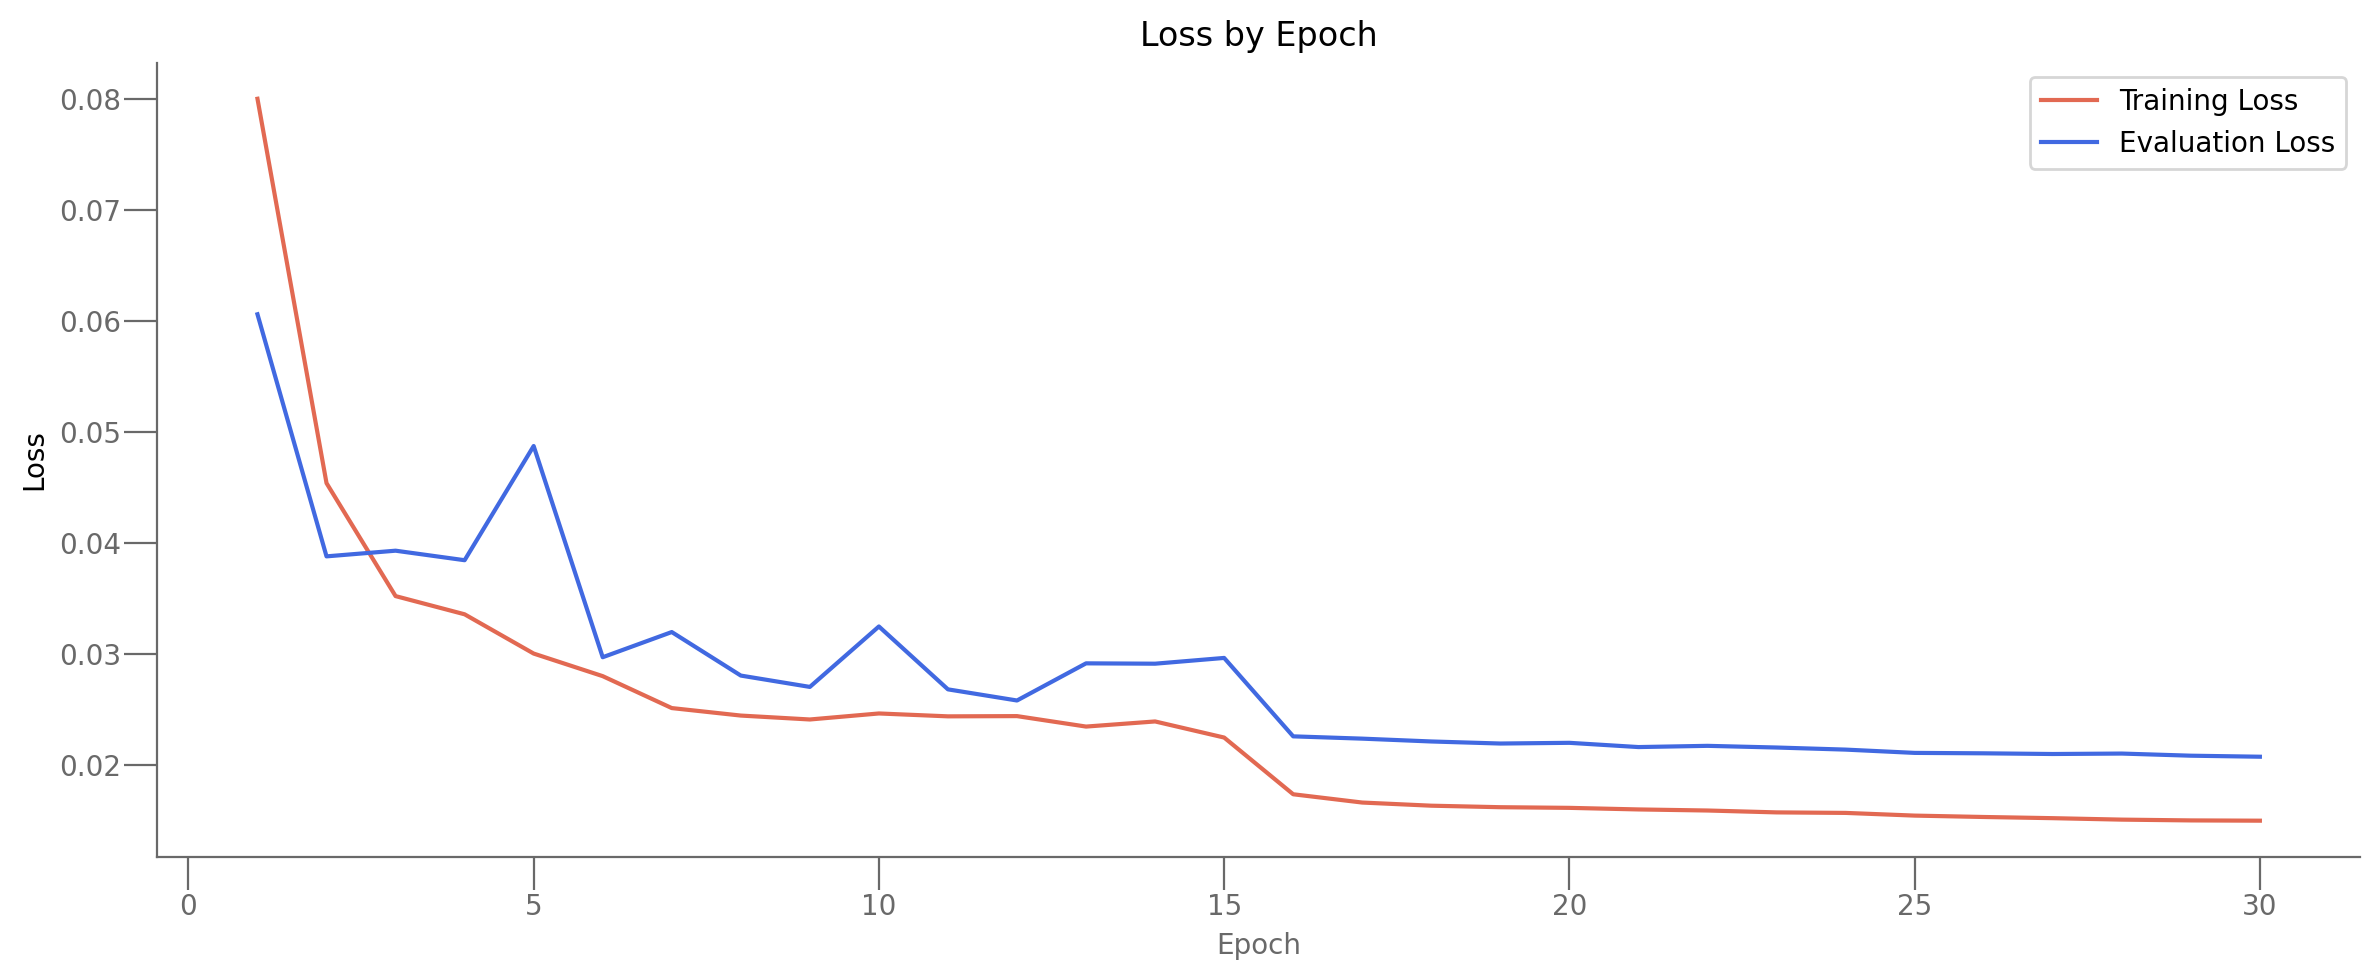


==================== TEST INFO ===================

Test_loss:0.0157, Test_r2:-0.4340


In [52]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True
        }
dataloader = trainer.train_test_val_split(dataset_gt, **dataloader_params2)


num_early_stop = 0
num_epochs = 30
lr = 0.01
model = RecurrentGCN(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, n_target=n_target, name="RecurrentGCNInicial")
losses,eval_losses, r2scores, e, h = train(model, dataloader, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses).mean(axis=1), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, predictions, real = test(model, dataloader, e, h)


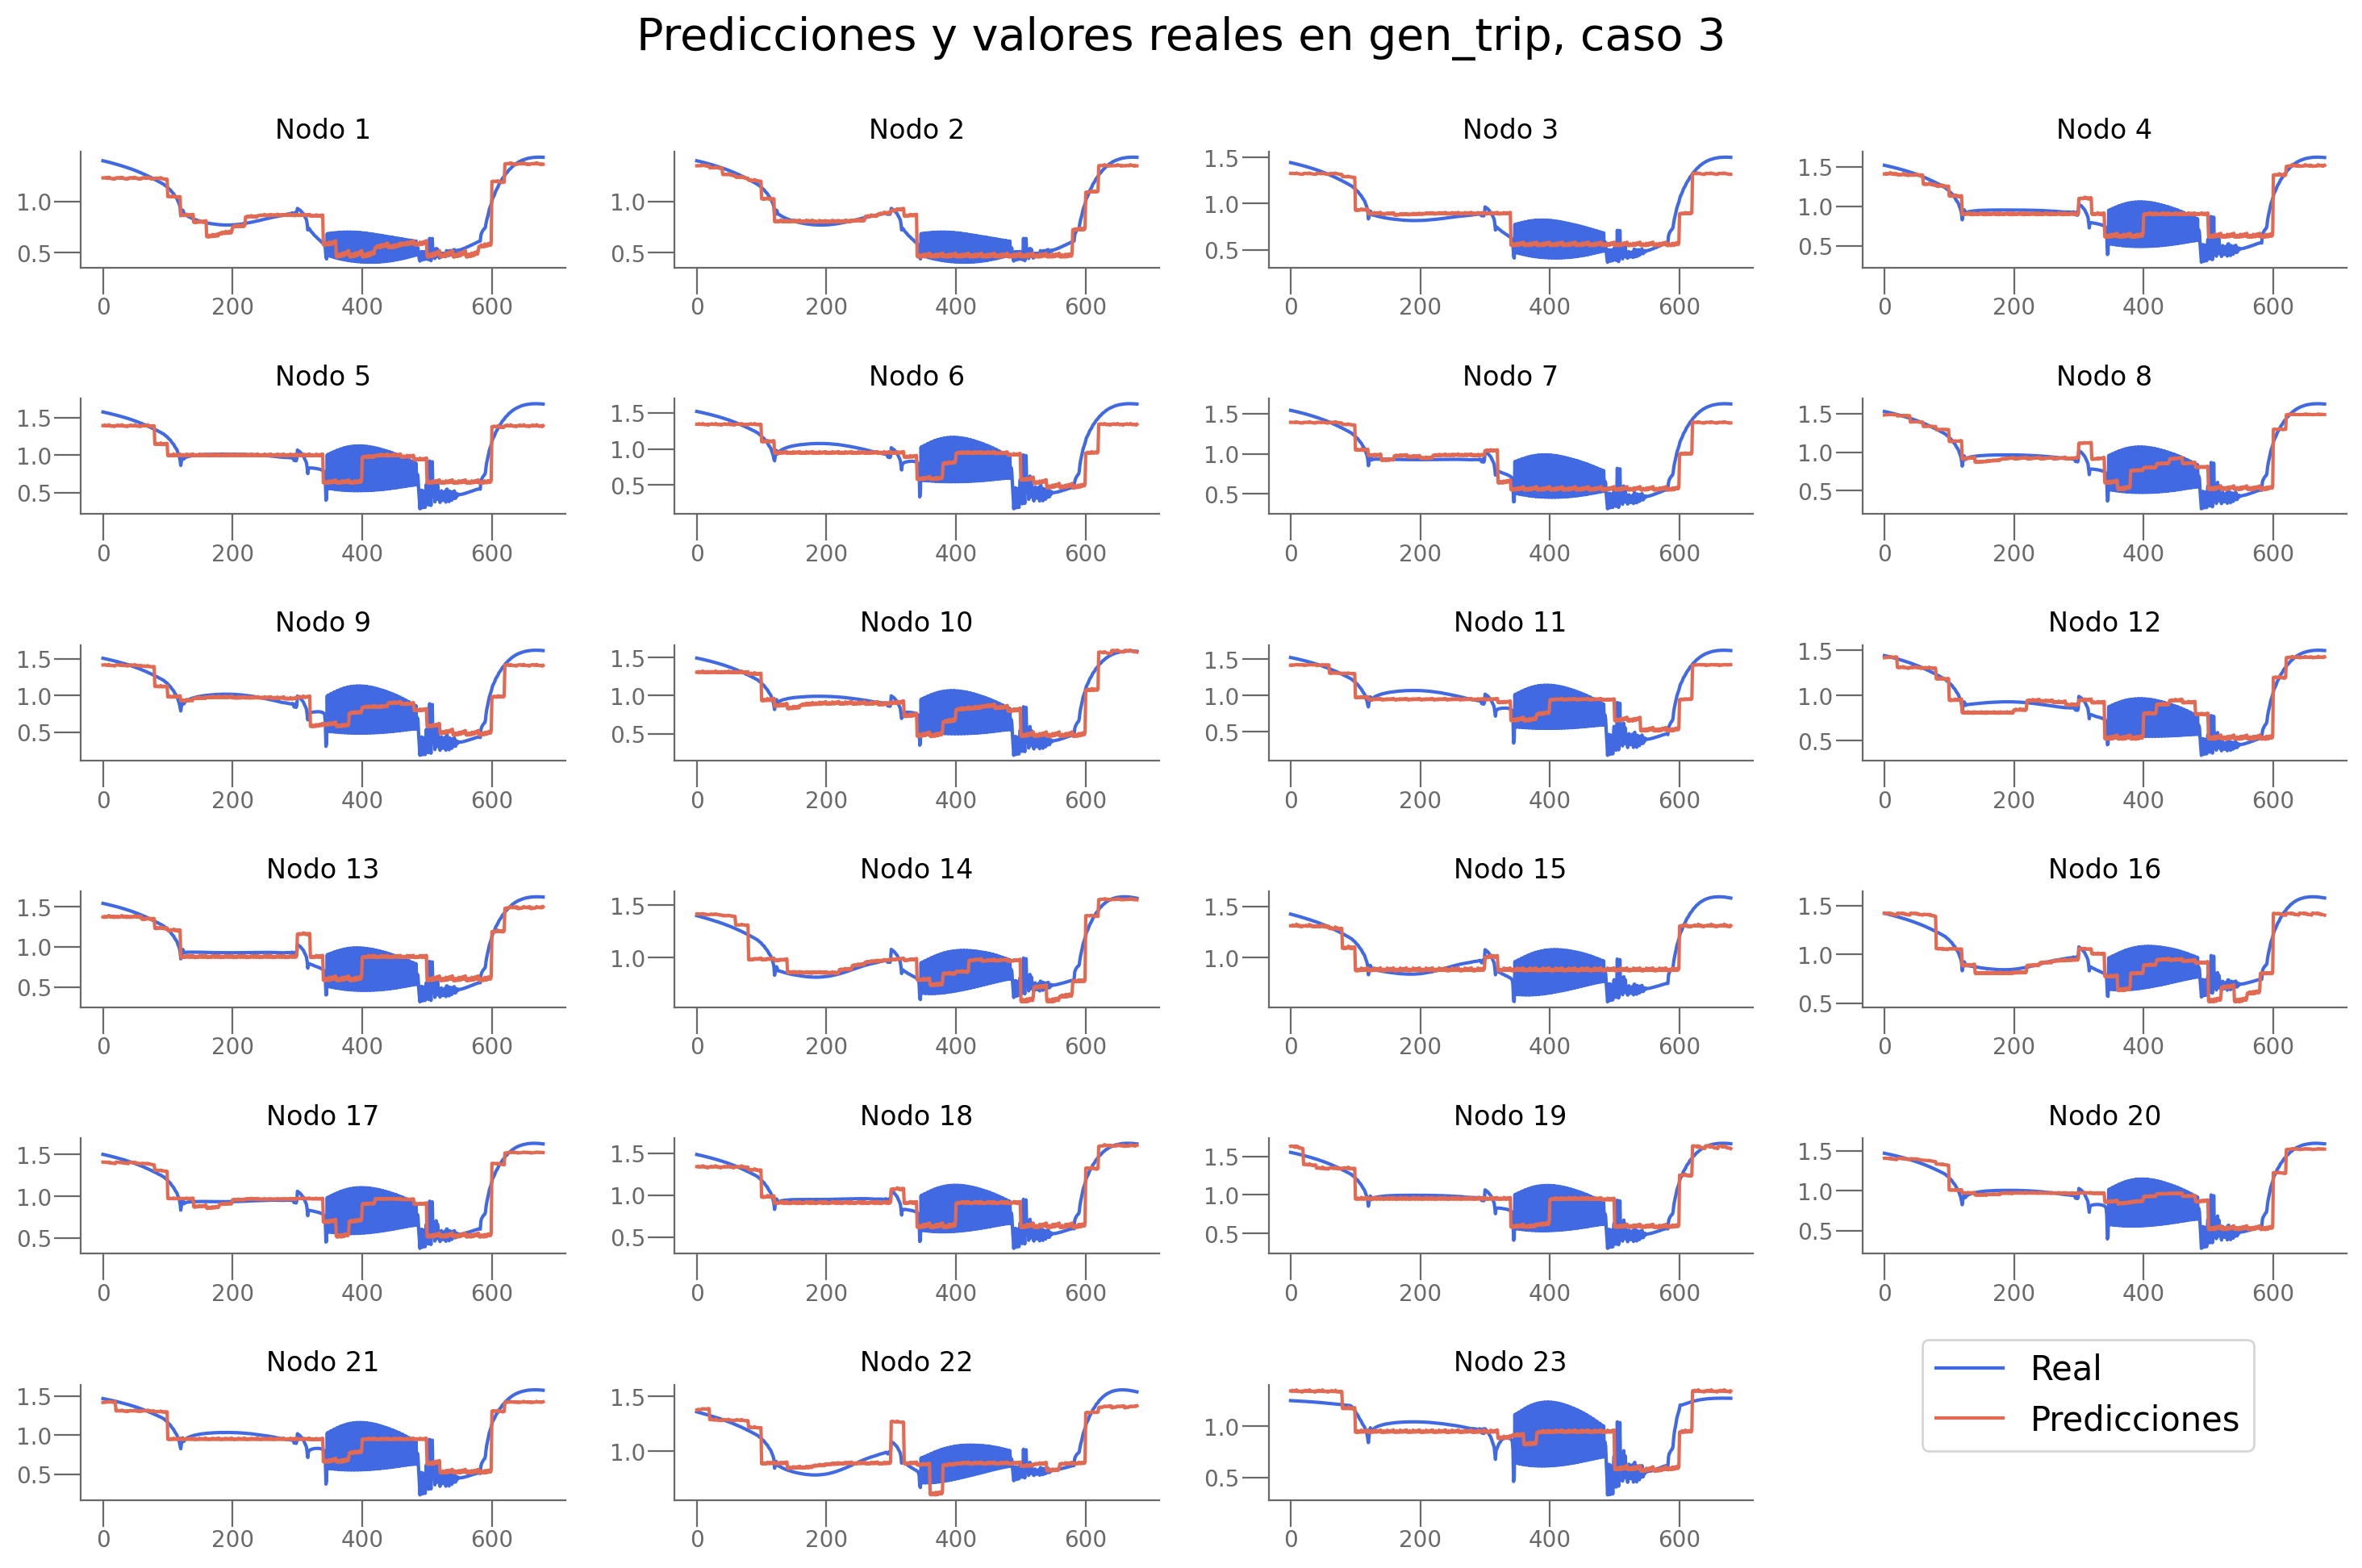

In [161]:
plot_predictions(predictions, real, n_target, 3, n_div_gt, problem)

### Bus trip

In [162]:
problem = "bus_trip"
dataset_bt, situations_bt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [55]:
n_div_bt = loader.div

#### Sencilla 

In [56]:
n_nodes =dataset_bt.features[0].shape[0]
n_target = dataset_bt.targets[0].shape[1]
n_features = dataset_bt[0].x.shape[1]
embedding_dim =5


==================== DATASET INFO ===================

Train dataset: 2310
Validation dataset: 285
Test dataset: 295

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 462
DataLoader for val set:
Number of batches: 57
DataLoader for test set:
Number of batches: 59

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.0946 | Eval Loss: 0.0521 | Eval R2: 0.1697 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.0545 | Eval Loss: 0.0364 | Eval R2: 0.3917 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.0428 | Eval Loss: 0.0321 | Eval R2: 0.4858 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.0384 | Eval Loss: 0.0282 | Eval R2: 0.5385 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.0380 | Eval Loss: 0.0296 | Eval R2: 0.5226 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0385 | Eval Loss: 0.0322 | Eval R2: 0.4694 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0310 | Eval Loss: 0.0276 | Eval R2: 0.5623 | LR: 0.010000
Epoch 8/30 | Train Loss: 0.0280 

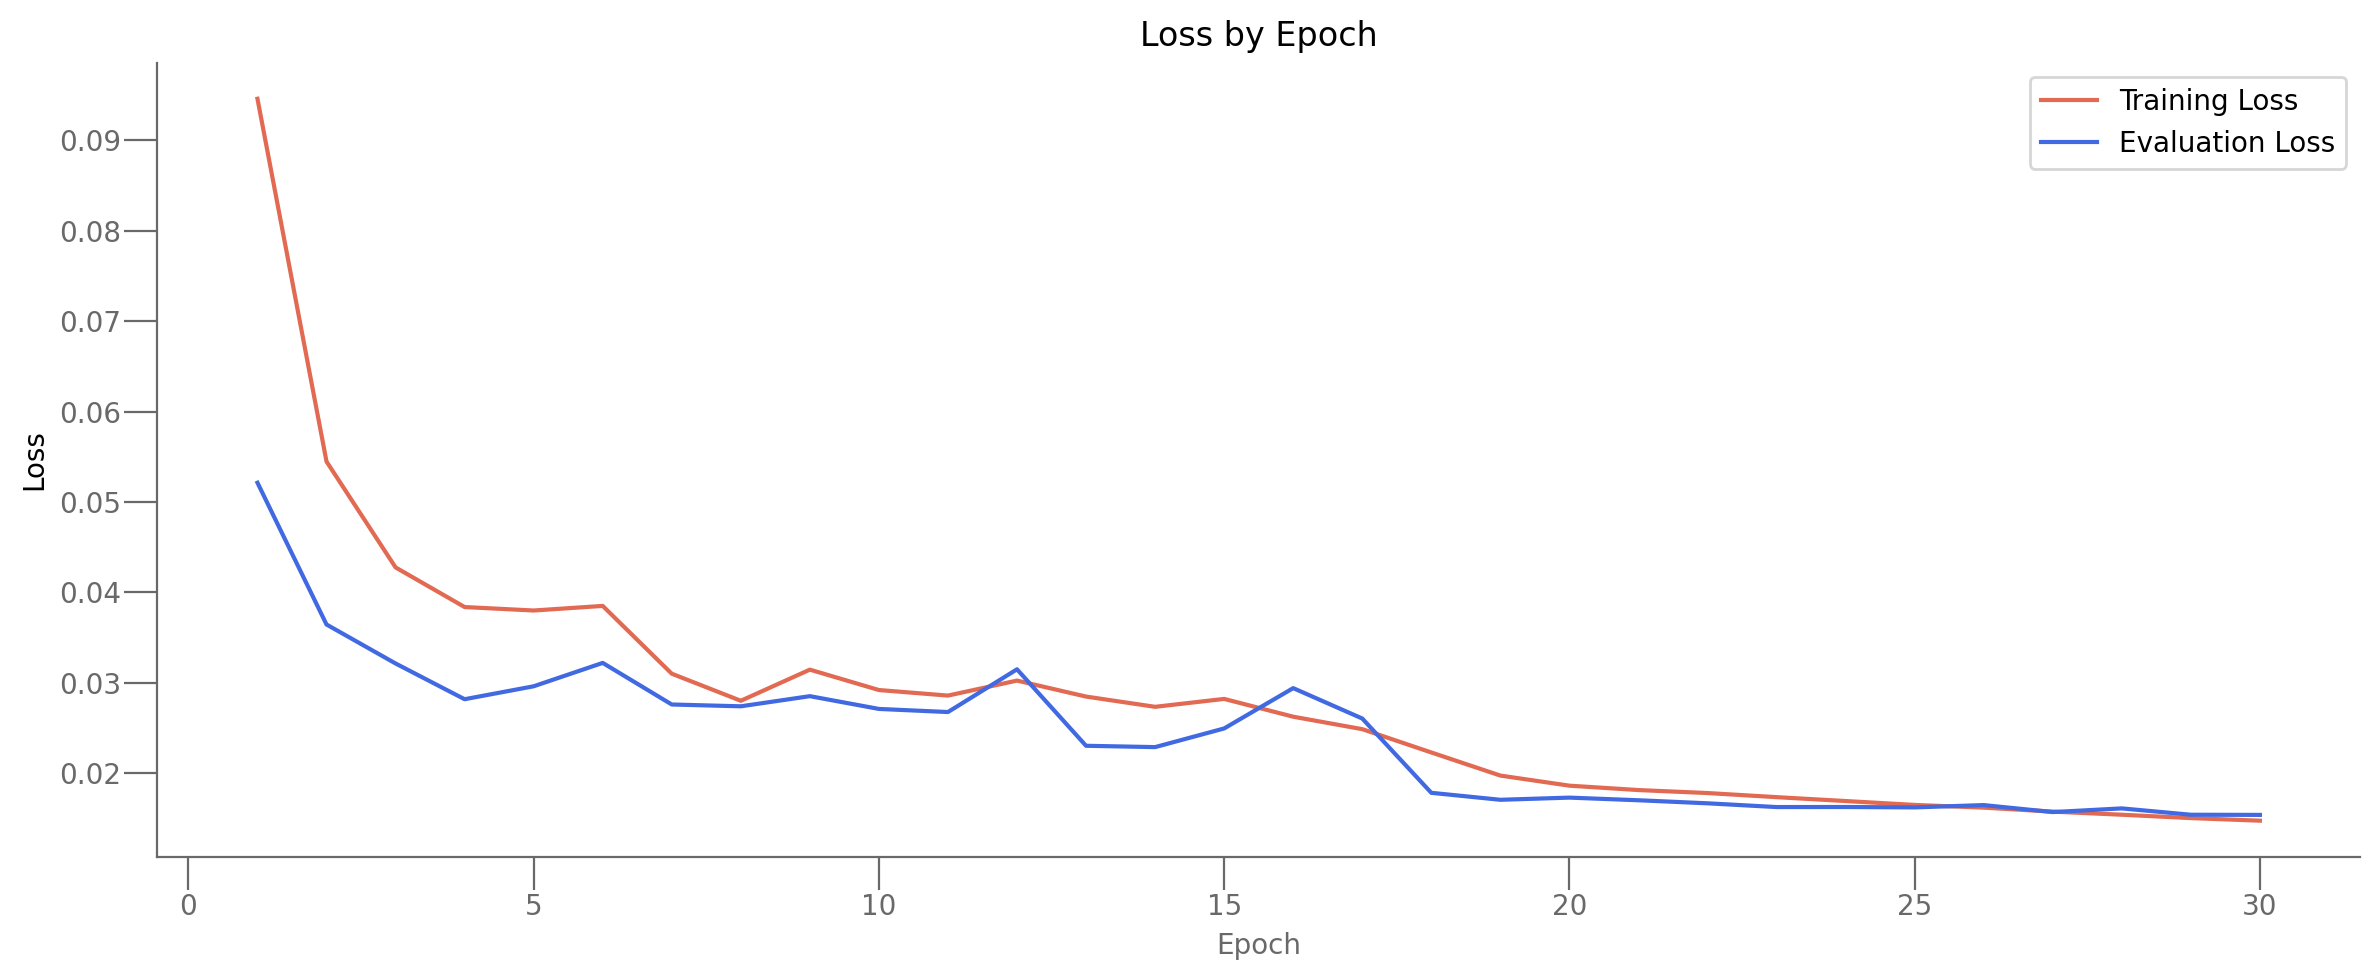


==================== TEST INFO ===================

Test_loss:0.0171, Test_r2:0.6698


In [57]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True
        }
dataloader_bt = trainer.train_test_val_split(dataset_bt, **dataloader_params2)


num_early_stop = 0
num_epochs = 30
lr = 0.01
model_bt = RecurrentGCN(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, n_target=n_target, name="RecurrentGCNInicial")
losses,eval_losses, r2scores, e, h = train(model_bt, dataloader_bt, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses).mean(axis=1), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, predictions_bt, real_bt = test(model_bt, dataloader_bt, e, h)


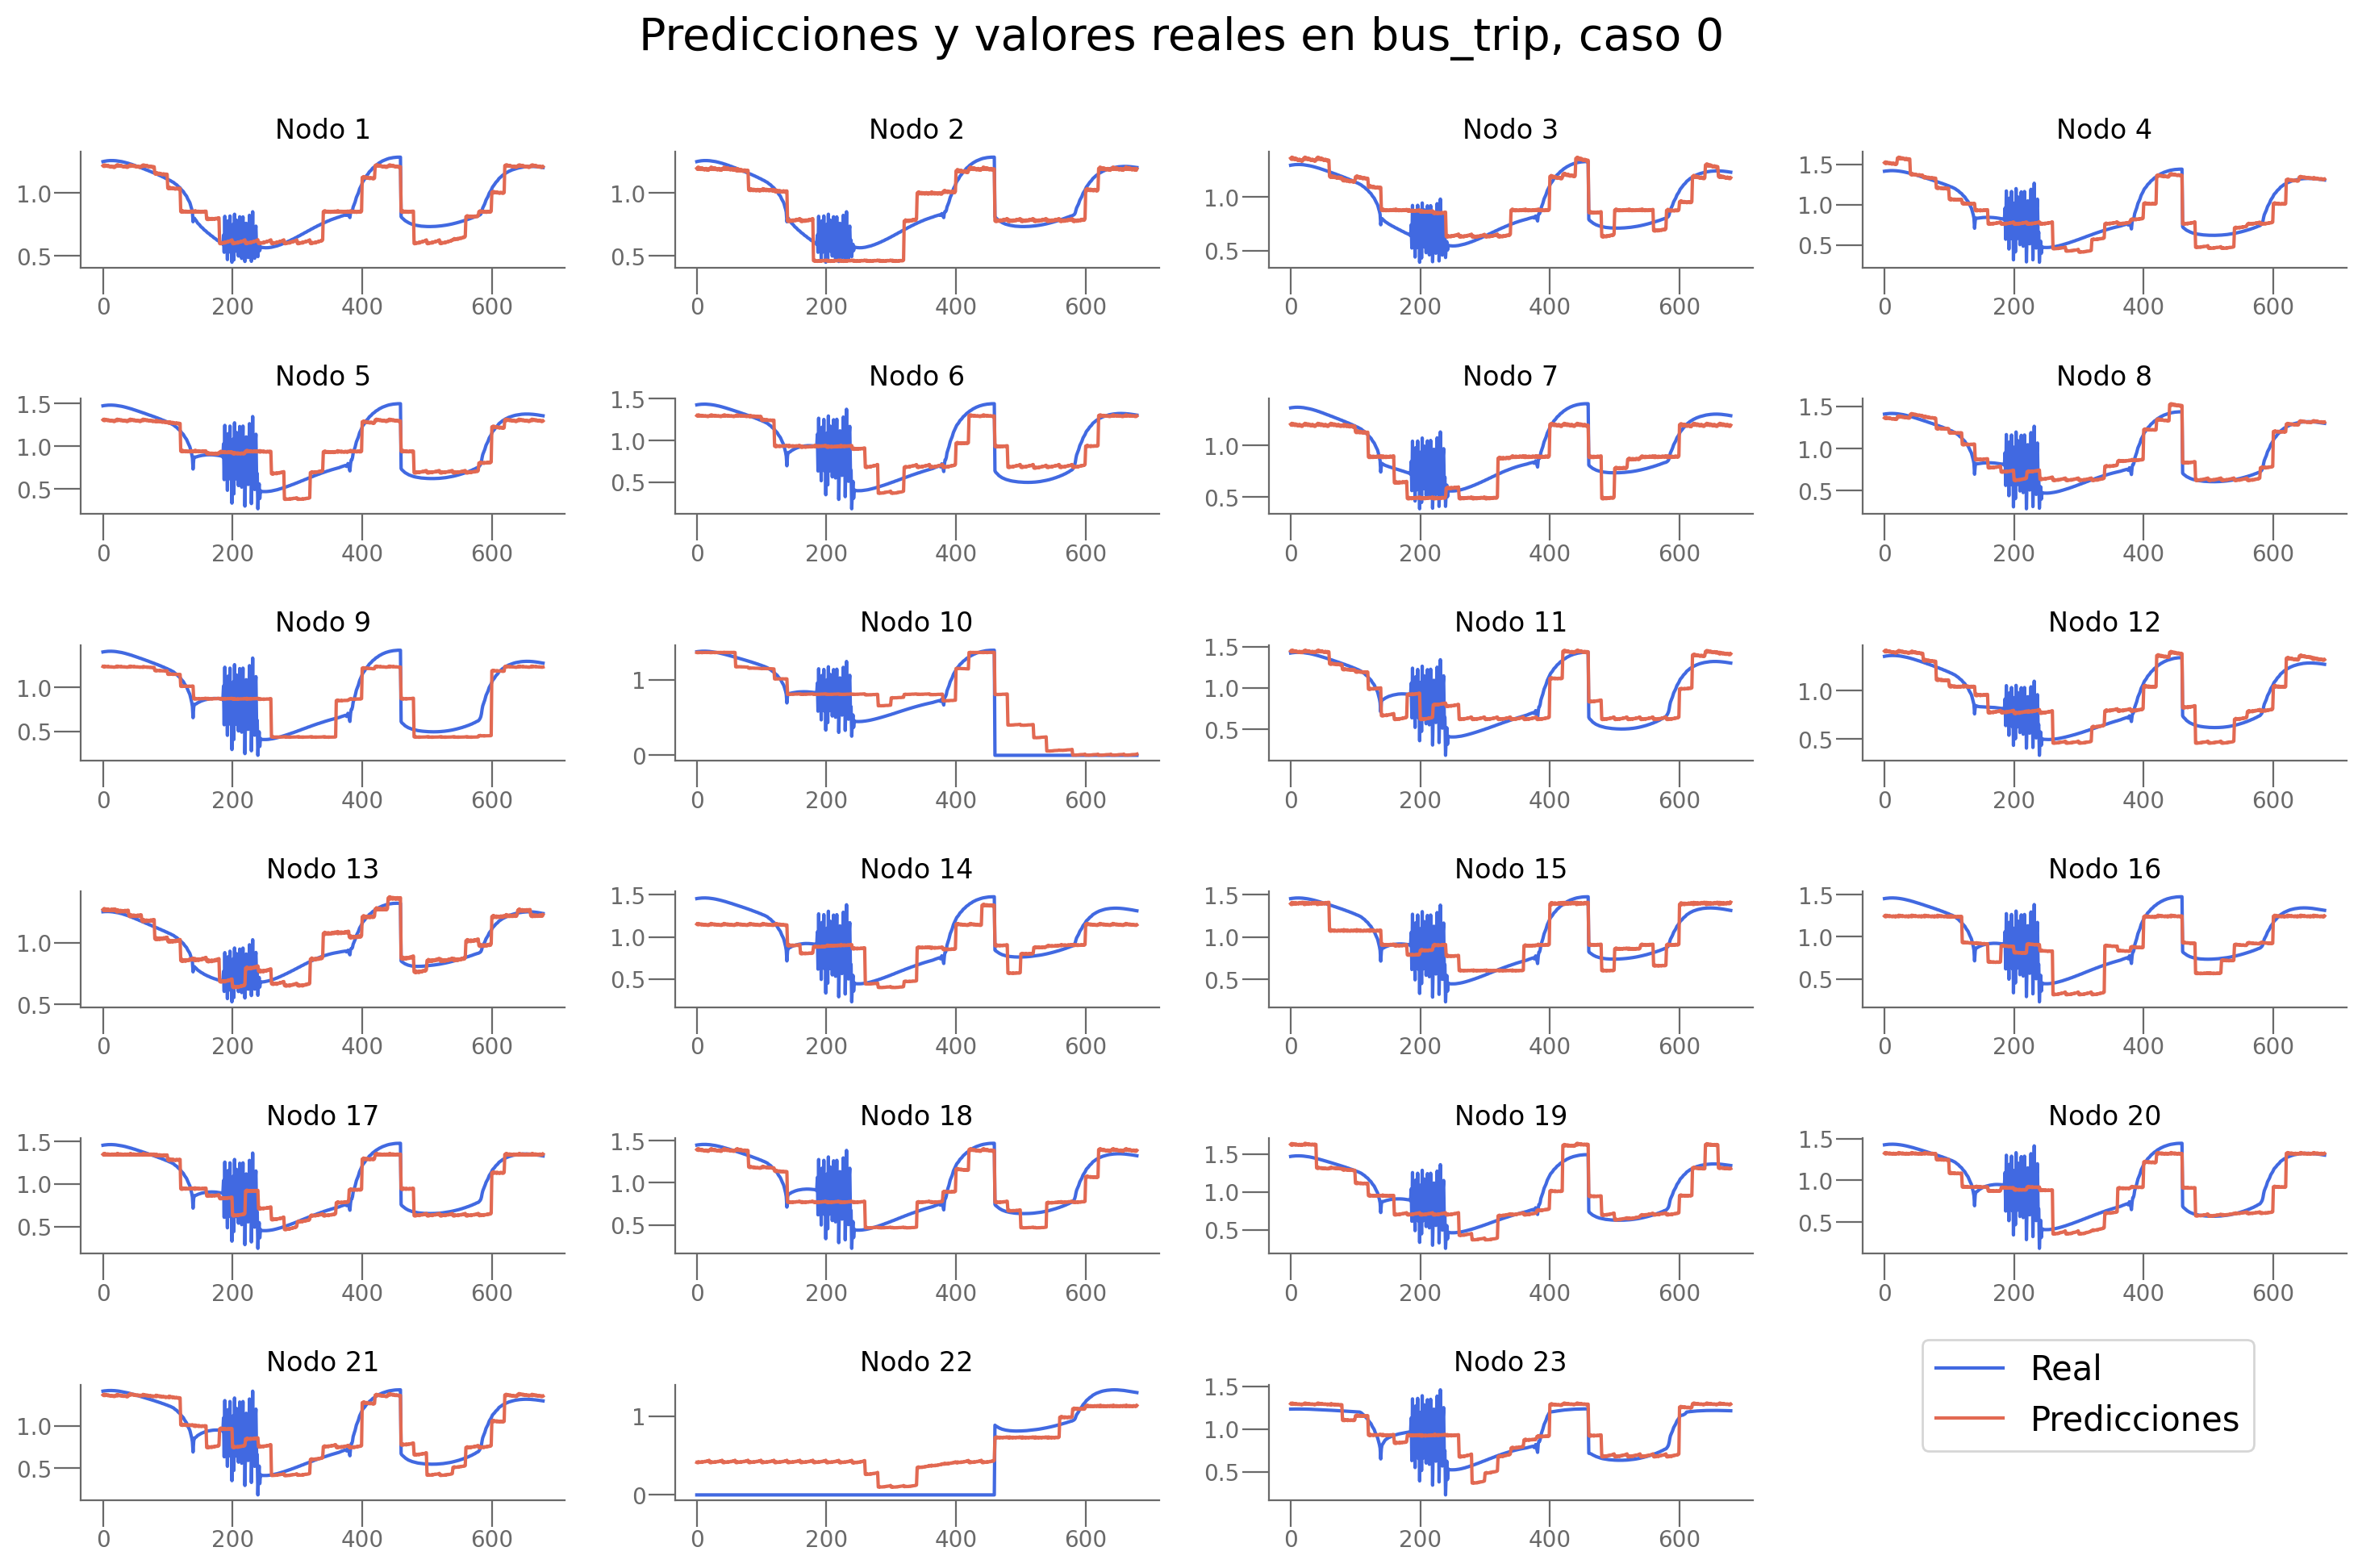

In [163]:
plot_predictions(predictions_bt, real_bt, n_target, 0, n_div_bt, problem)

### Bus fault

In [164]:
problem = "bus_fault"
dataset_bf, situations_bf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  86


In [60]:
n_div_bf = loader.div

#### Sencilla 

In [61]:
n_nodes =dataset_bf.features[0].shape[0]
n_target = dataset_bf.targets[0].shape[1]
n_features = dataset_bf[0].x.shape[1]
embedding_dim =5


==================== DATASET INFO ===================

Train dataset: 2310
Validation dataset: 285
Test dataset: 295

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 462
DataLoader for val set:
Number of batches: 57
DataLoader for test set:
Number of batches: 59

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.1286 | Eval Loss: 0.0918 | Eval R2: -0.8247 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.0682 | Eval Loss: 0.0735 | Eval R2: -0.4430 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.0586 | Eval Loss: 0.0805 | Eval R2: -0.5905 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.0538 | Eval Loss: 0.0640 | Eval R2: -0.2227 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.0527 | Eval Loss: 0.0647 | Eval R2: -0.2368 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0472 | Eval Loss: 0.0627 | Eval R2: -0.1720 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0553 | Eval Loss: 0.0655 | Eval R2: -0.2749 | LR: 0.010000
Epoch 8/30 | Train Loss: 

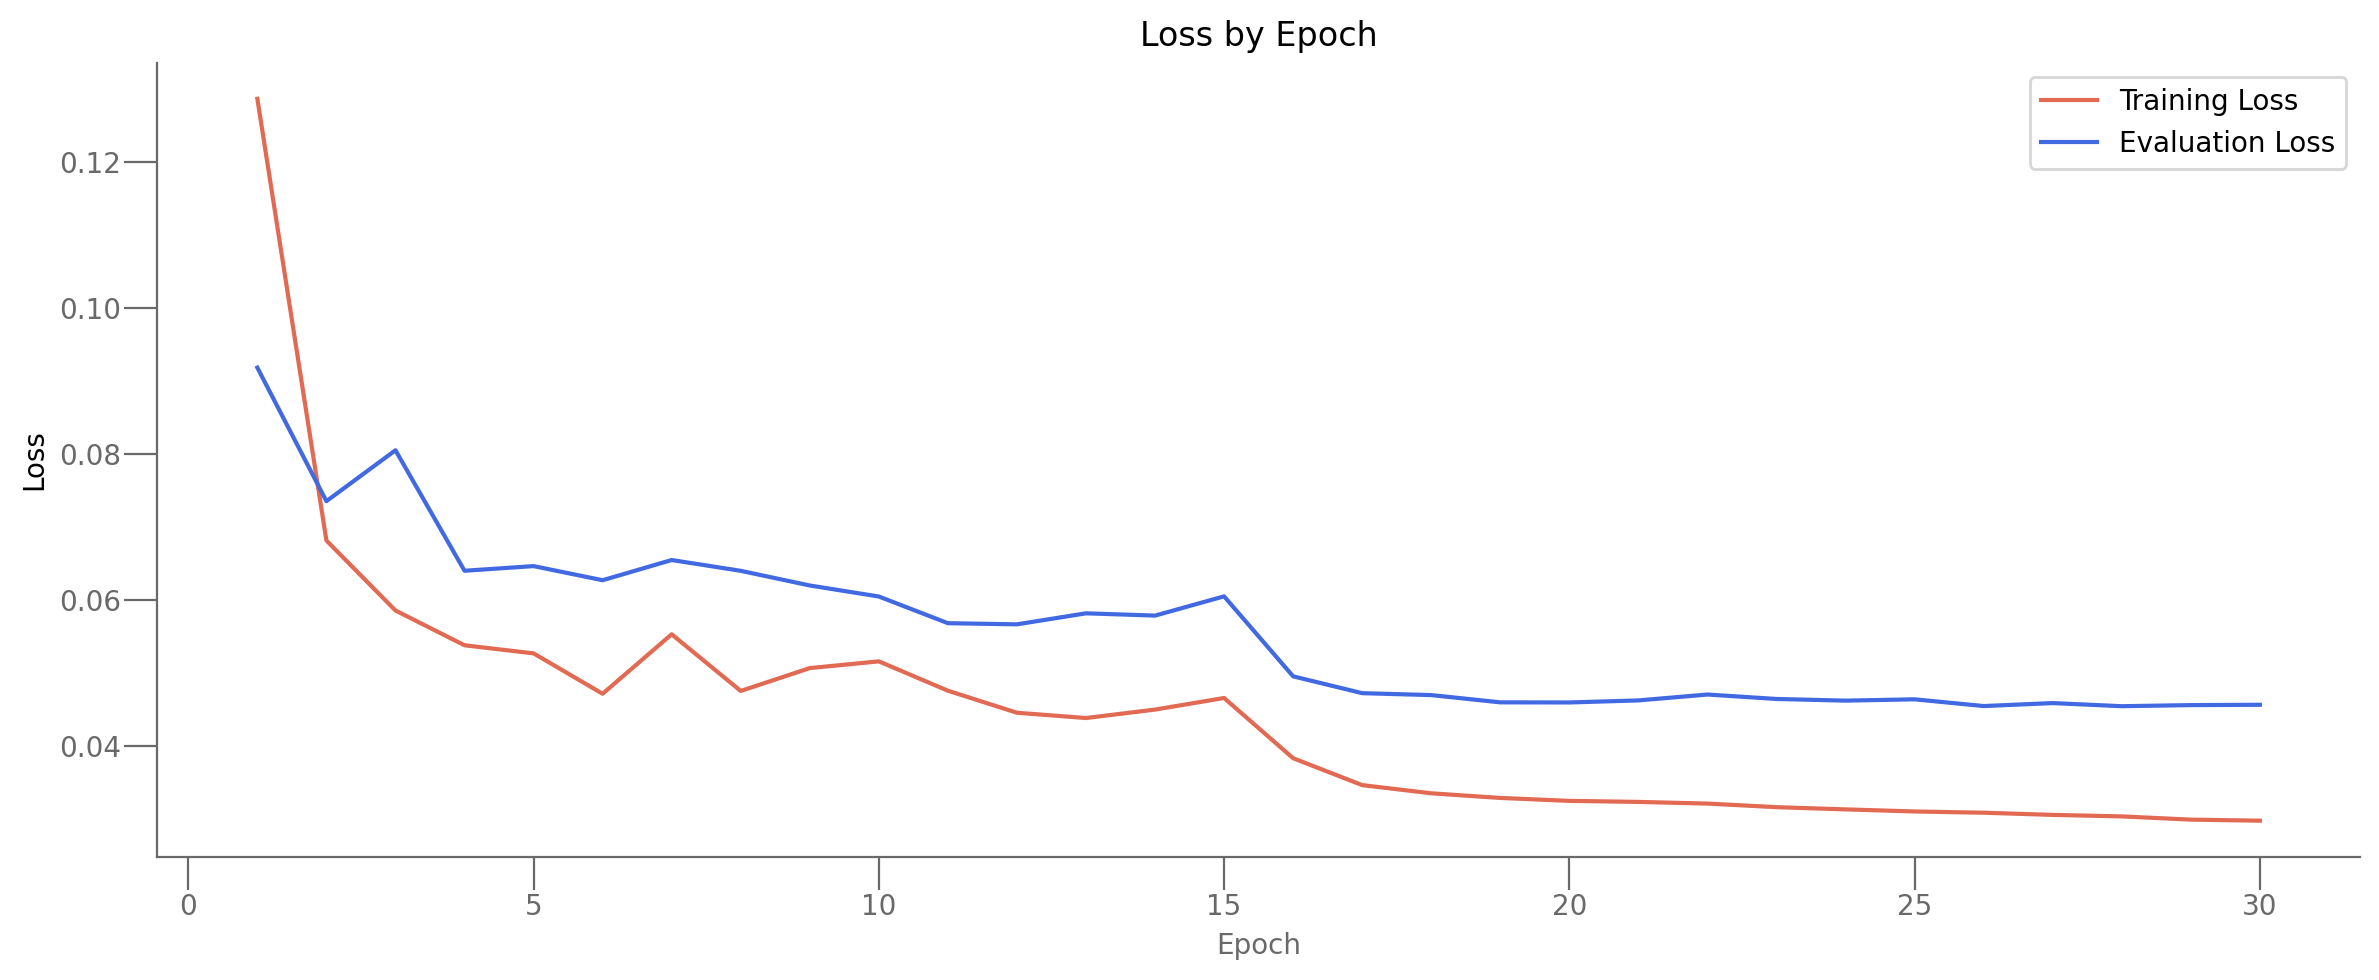


==================== TEST INFO ===================

Test_loss:0.0192, Test_r2:-2.9270


In [62]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True
        }
dataloader_bf = trainer.train_test_val_split(dataset_bf, **dataloader_params2)


num_early_stop = 0
num_epochs = 30
lr = 0.01
model_bf = RecurrentGCN(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, n_target=n_target, name="RecurrentGCNInicial")
losses,eval_losses, r2scores, e, h = train(model_bf, dataloader_bf, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses).mean(axis=1), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, predictions_bf, real_bf = test(model_bf, dataloader_bf, e, h)


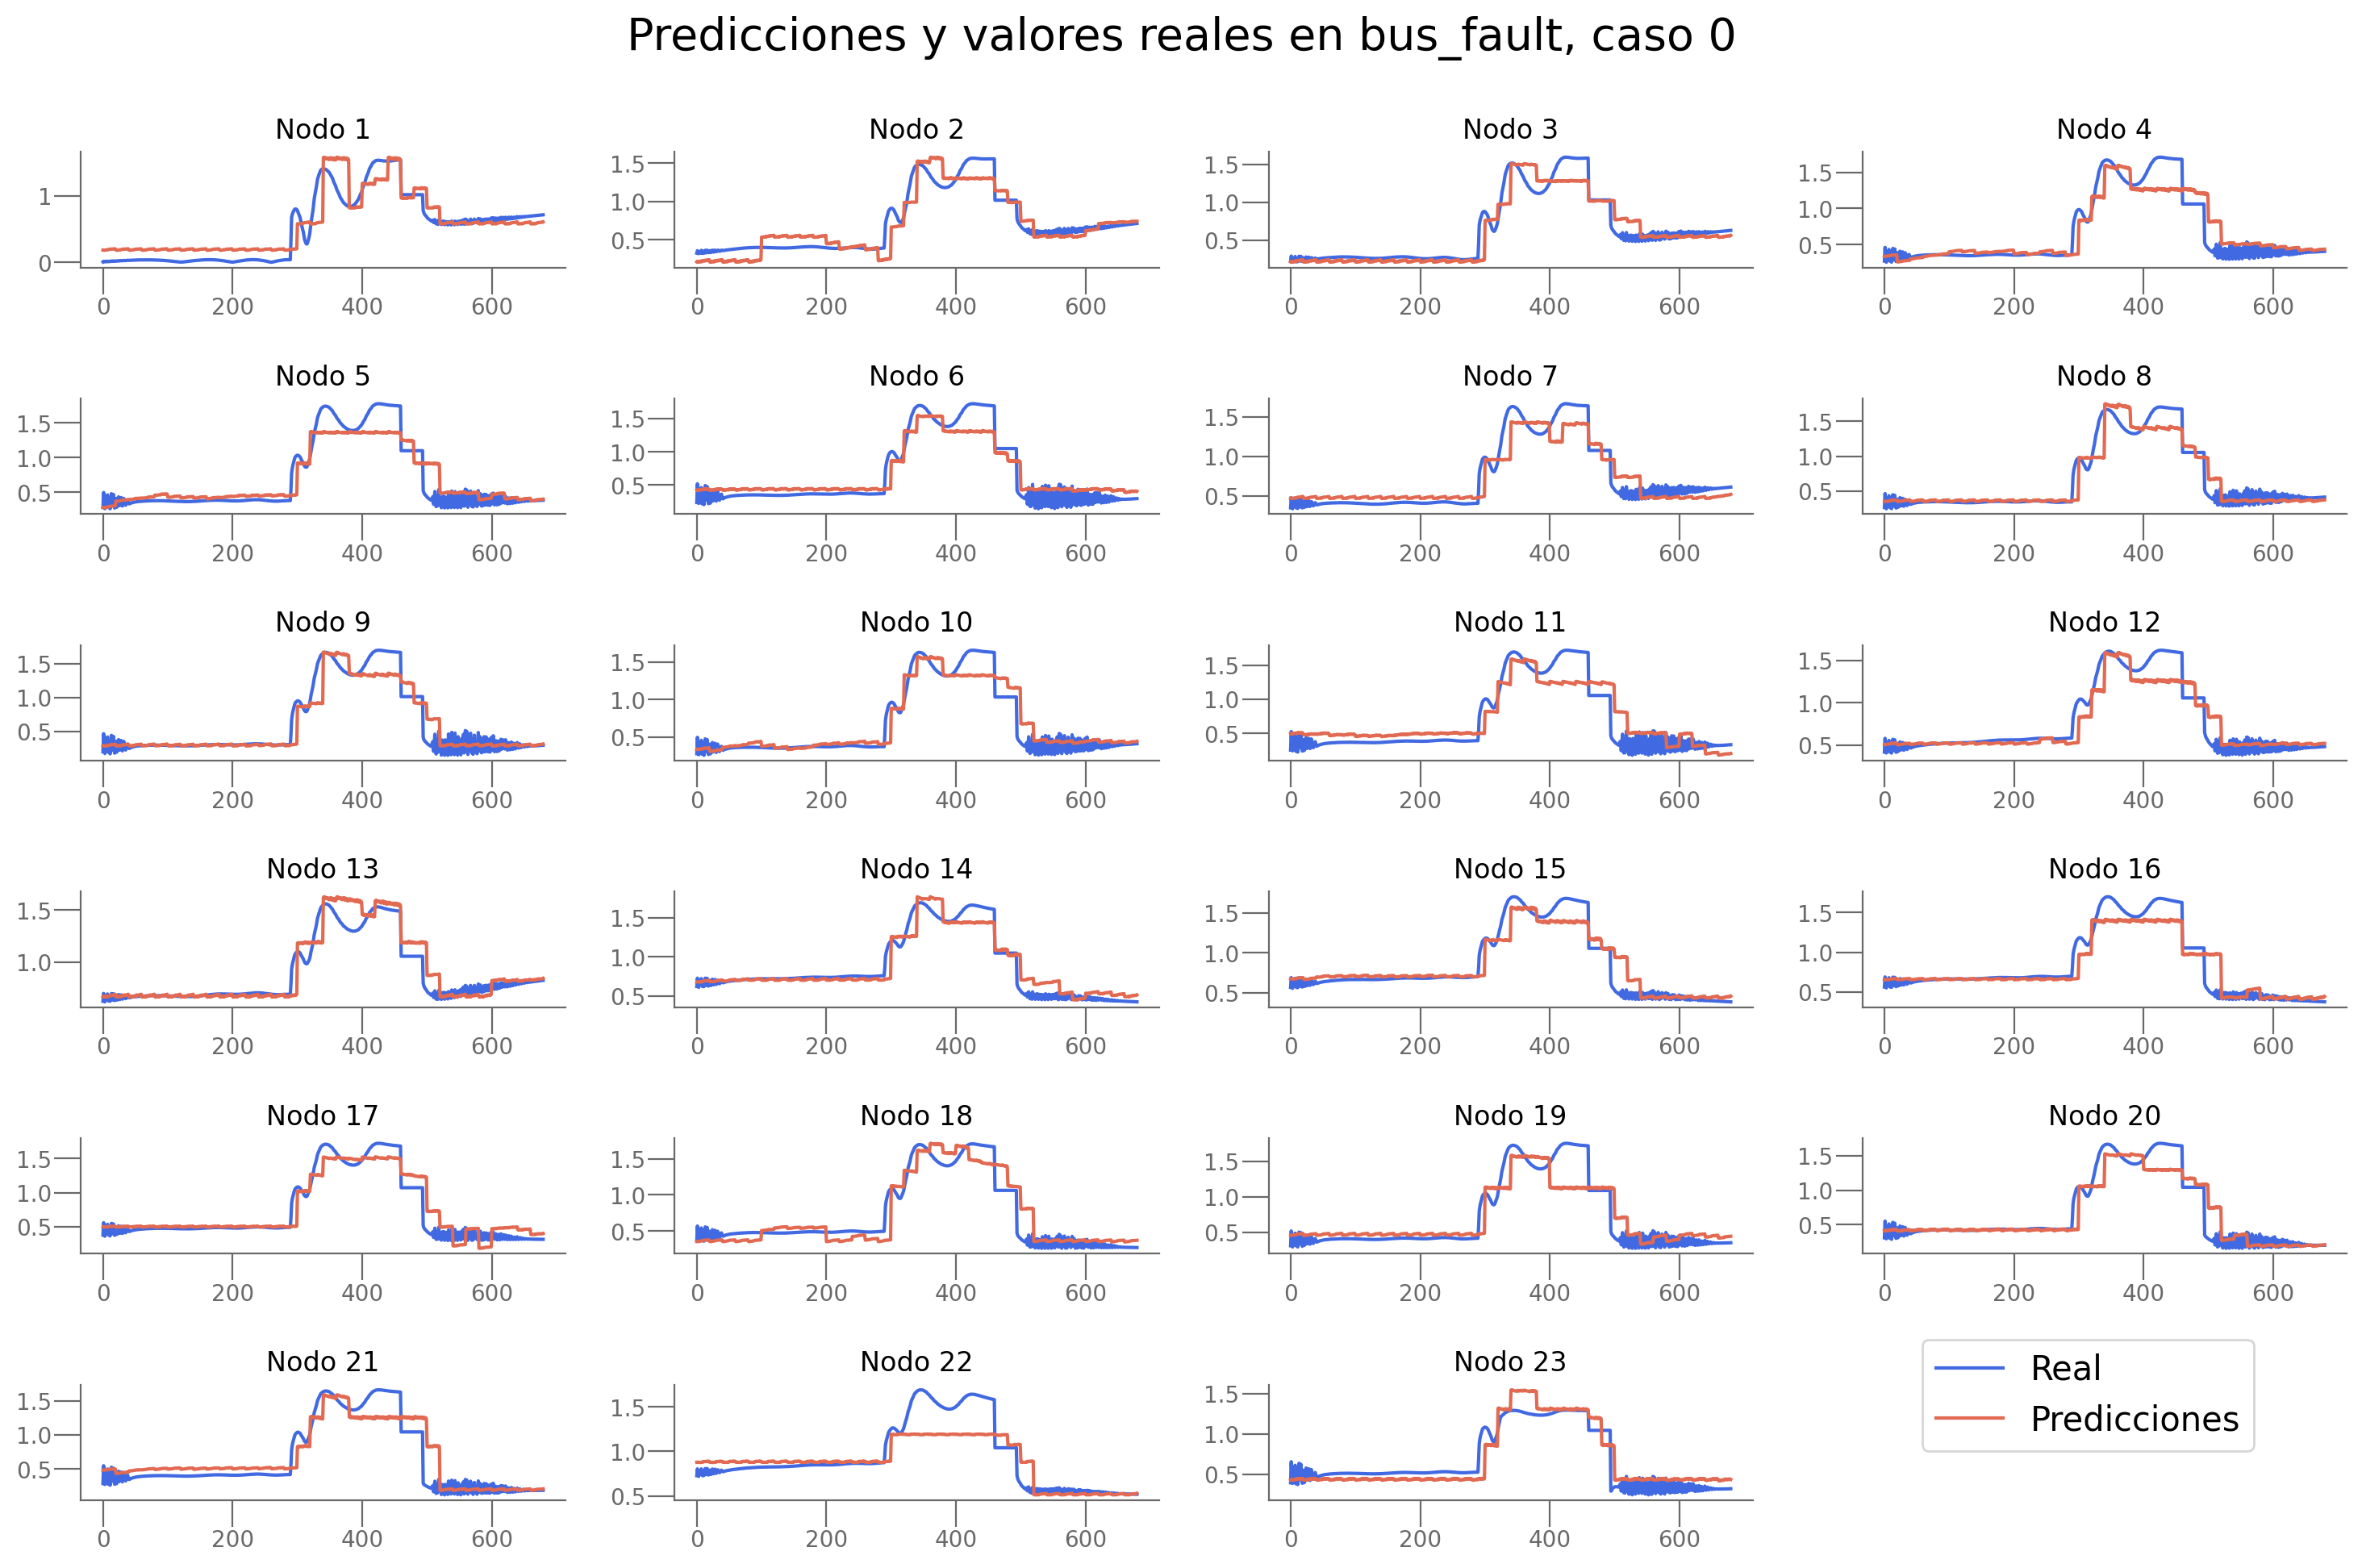

In [165]:
plot_predictions(predictions_bf, real_bf, n_target, 0,n_div_bf, problem)

### Branch Fault

In [166]:
problem = "branch_fault"
dataset_brf, situations_brf = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)


Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  92


In [65]:
n_div_brf = loader.div

#### Sencilla 

In [66]:
n_nodes =dataset_brf.features[0].shape[0]
n_target = dataset_brf.targets[0].shape[1]
n_features = dataset_brf[0].x.shape[1]
embedding_dim =5


==================== DATASET INFO ===================

Train dataset: 2475
Validation dataset: 315
Test dataset: 304

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 495
DataLoader for val set:
Number of batches: 63
DataLoader for test set:
Number of batches: 60

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.0929 | Eval Loss: 0.0580 | Eval R2: -0.6116 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.0572 | Eval Loss: 0.0517 | Eval R2: -0.4414 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.0538 | Eval Loss: 0.0625 | Eval R2: -0.7401 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.0547 | Eval Loss: 0.0499 | Eval R2: -0.3201 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.0516 | Eval Loss: 0.0445 | Eval R2: -0.2119 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0525 | Eval Loss: 0.0504 | Eval R2: -0.3916 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0490 | Eval Loss: 0.0441 | Eval R2: -0.2211 | LR: 0.010000
Epoch 8/30 | Train Loss: 

Epoch 12/30 | Train Loss: 0.0429 | Eval Loss: 0.0387 | Eval R2: 0.1238 | LR: 0.001000
Epoch 13/30 | Train Loss: 0.0382 | Eval Loss: 0.0375 | Eval R2: 0.1481 | LR: 0.001000
Epoch 14/30 | Train Loss: 0.0370 | Eval Loss: 0.0365 | Eval R2: 0.1760 | LR: 0.001000
Epoch 15/30 | Train Loss: 0.0360 | Eval Loss: 0.0361 | Eval R2: 0.1837 | LR: 0.001000
Epoch 16/30 | Train Loss: 0.0353 | Eval Loss: 0.0359 | Eval R2: 0.1954 | LR: 0.001000
Epoch 17/30 | Train Loss: 0.0347 | Eval Loss: 0.0351 | Eval R2: 0.2188 | LR: 0.001000
Epoch 18/30 | Train Loss: 0.0343 | Eval Loss: 0.0348 | Eval R2: 0.2263 | LR: 0.001000
Epoch 19/30 | Train Loss: 0.0338 | Eval Loss: 0.0344 | Eval R2: 0.2358 | LR: 0.001000
Epoch 20/30 | Train Loss: 0.0337 | Eval Loss: 0.0343 | Eval R2: 0.2380 | LR: 0.001000
Epoch 21/30 | Train Loss: 0.0332 | Eval Loss: 0.0341 | Eval R2: 0.2461 | LR: 0.001000
Epoch 22/30 | Train Loss: 0.0330 | Eval Loss: 0.0338 | Eval R2: 0.2552 | LR: 0.001000
Epoch 23/30 | Train Loss: 0.0326 | Eval Loss: 0.0337 |

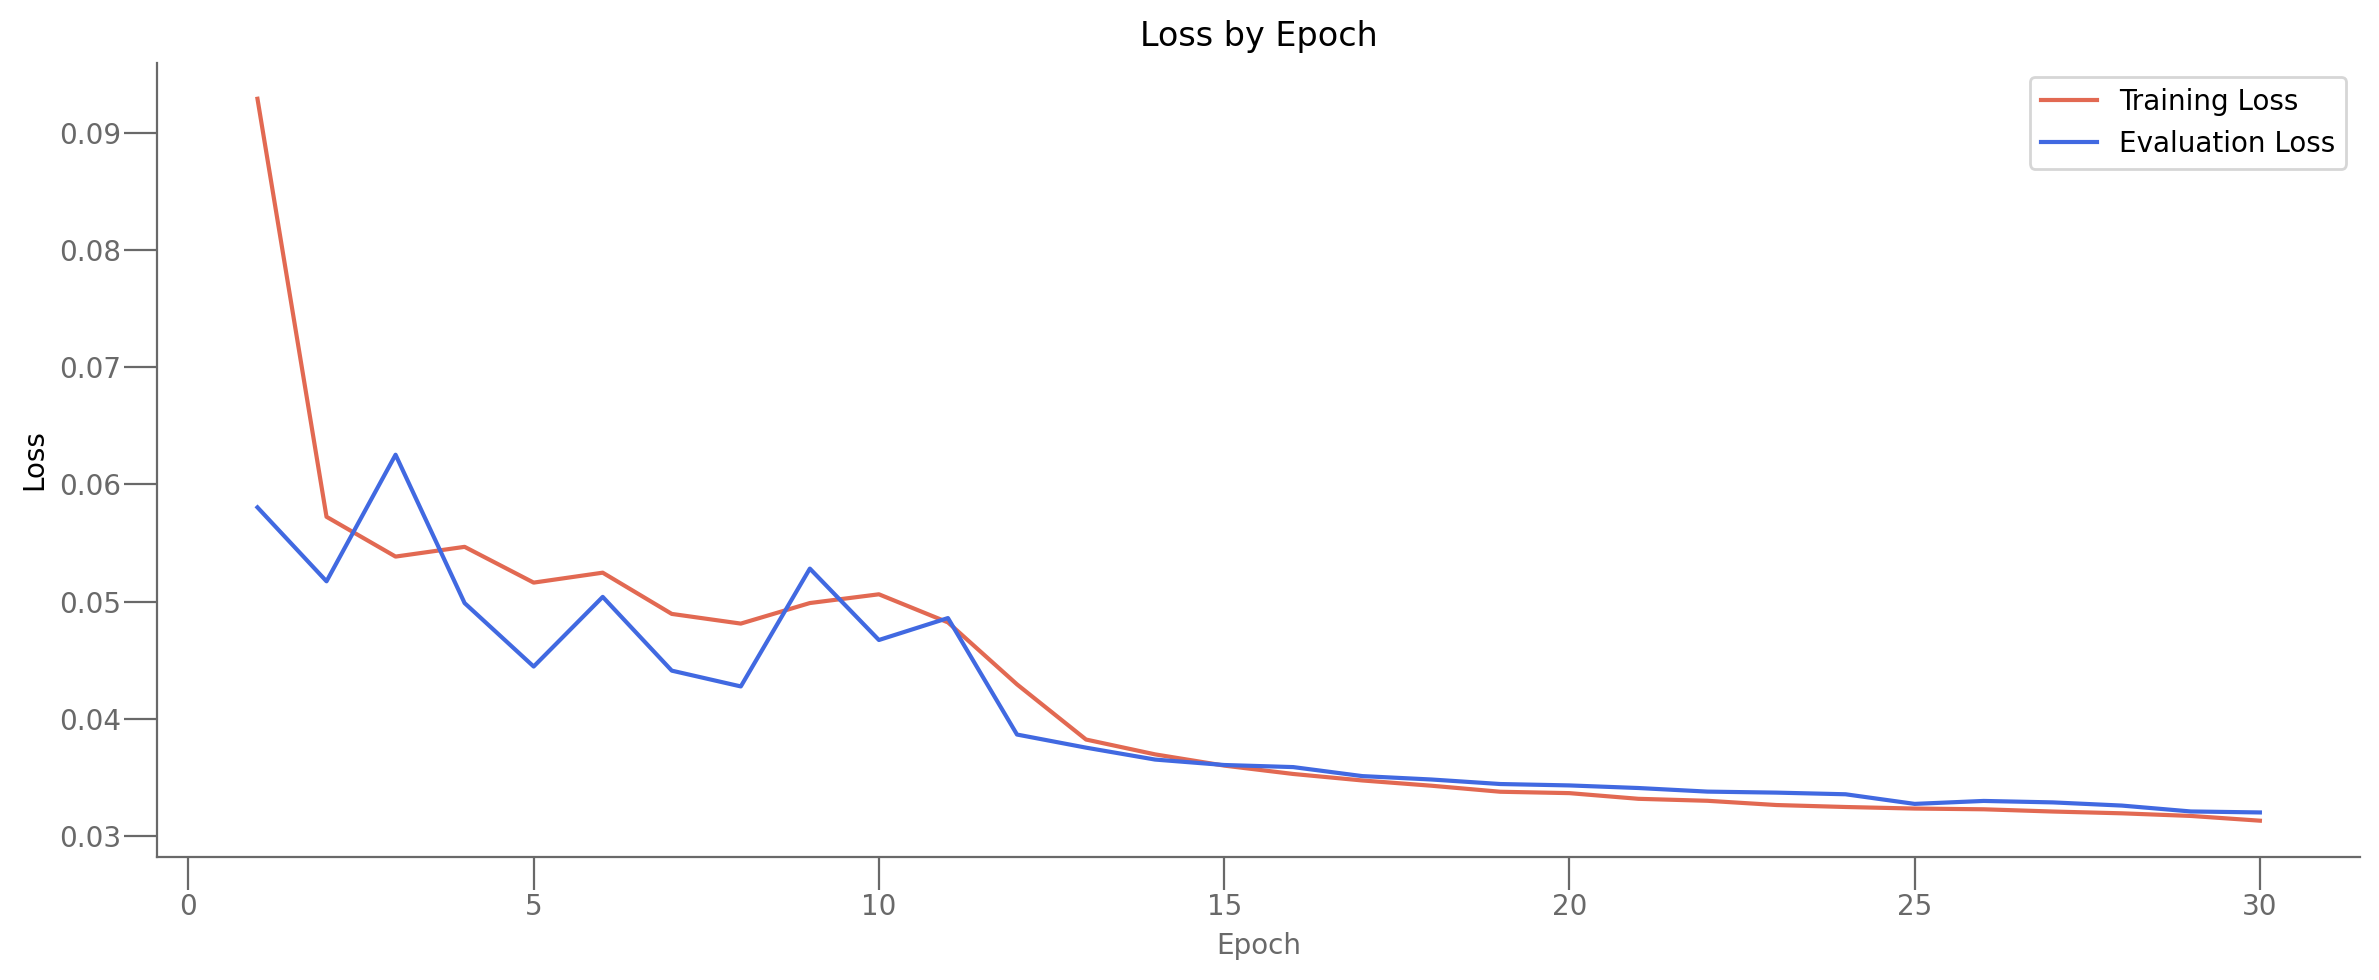


==================== TEST INFO ===================

Test_loss:0.0262, Test_r2:0.6239


In [67]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True
        }
dataloader_brf = trainer.train_test_val_split(dataset_brf, **dataloader_params2)


num_early_stop = 0
num_epochs = 30
lr = 0.01
model_brf = RecurrentGCN(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, n_target=n_target, name="RecurrentGCNInicial")
losses,eval_losses, r2scores, e, h = train(model_brf, dataloader_brf, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses).mean(axis=1), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, predictions_brf, real_brf = test(model_brf, dataloader_brf, e, h)


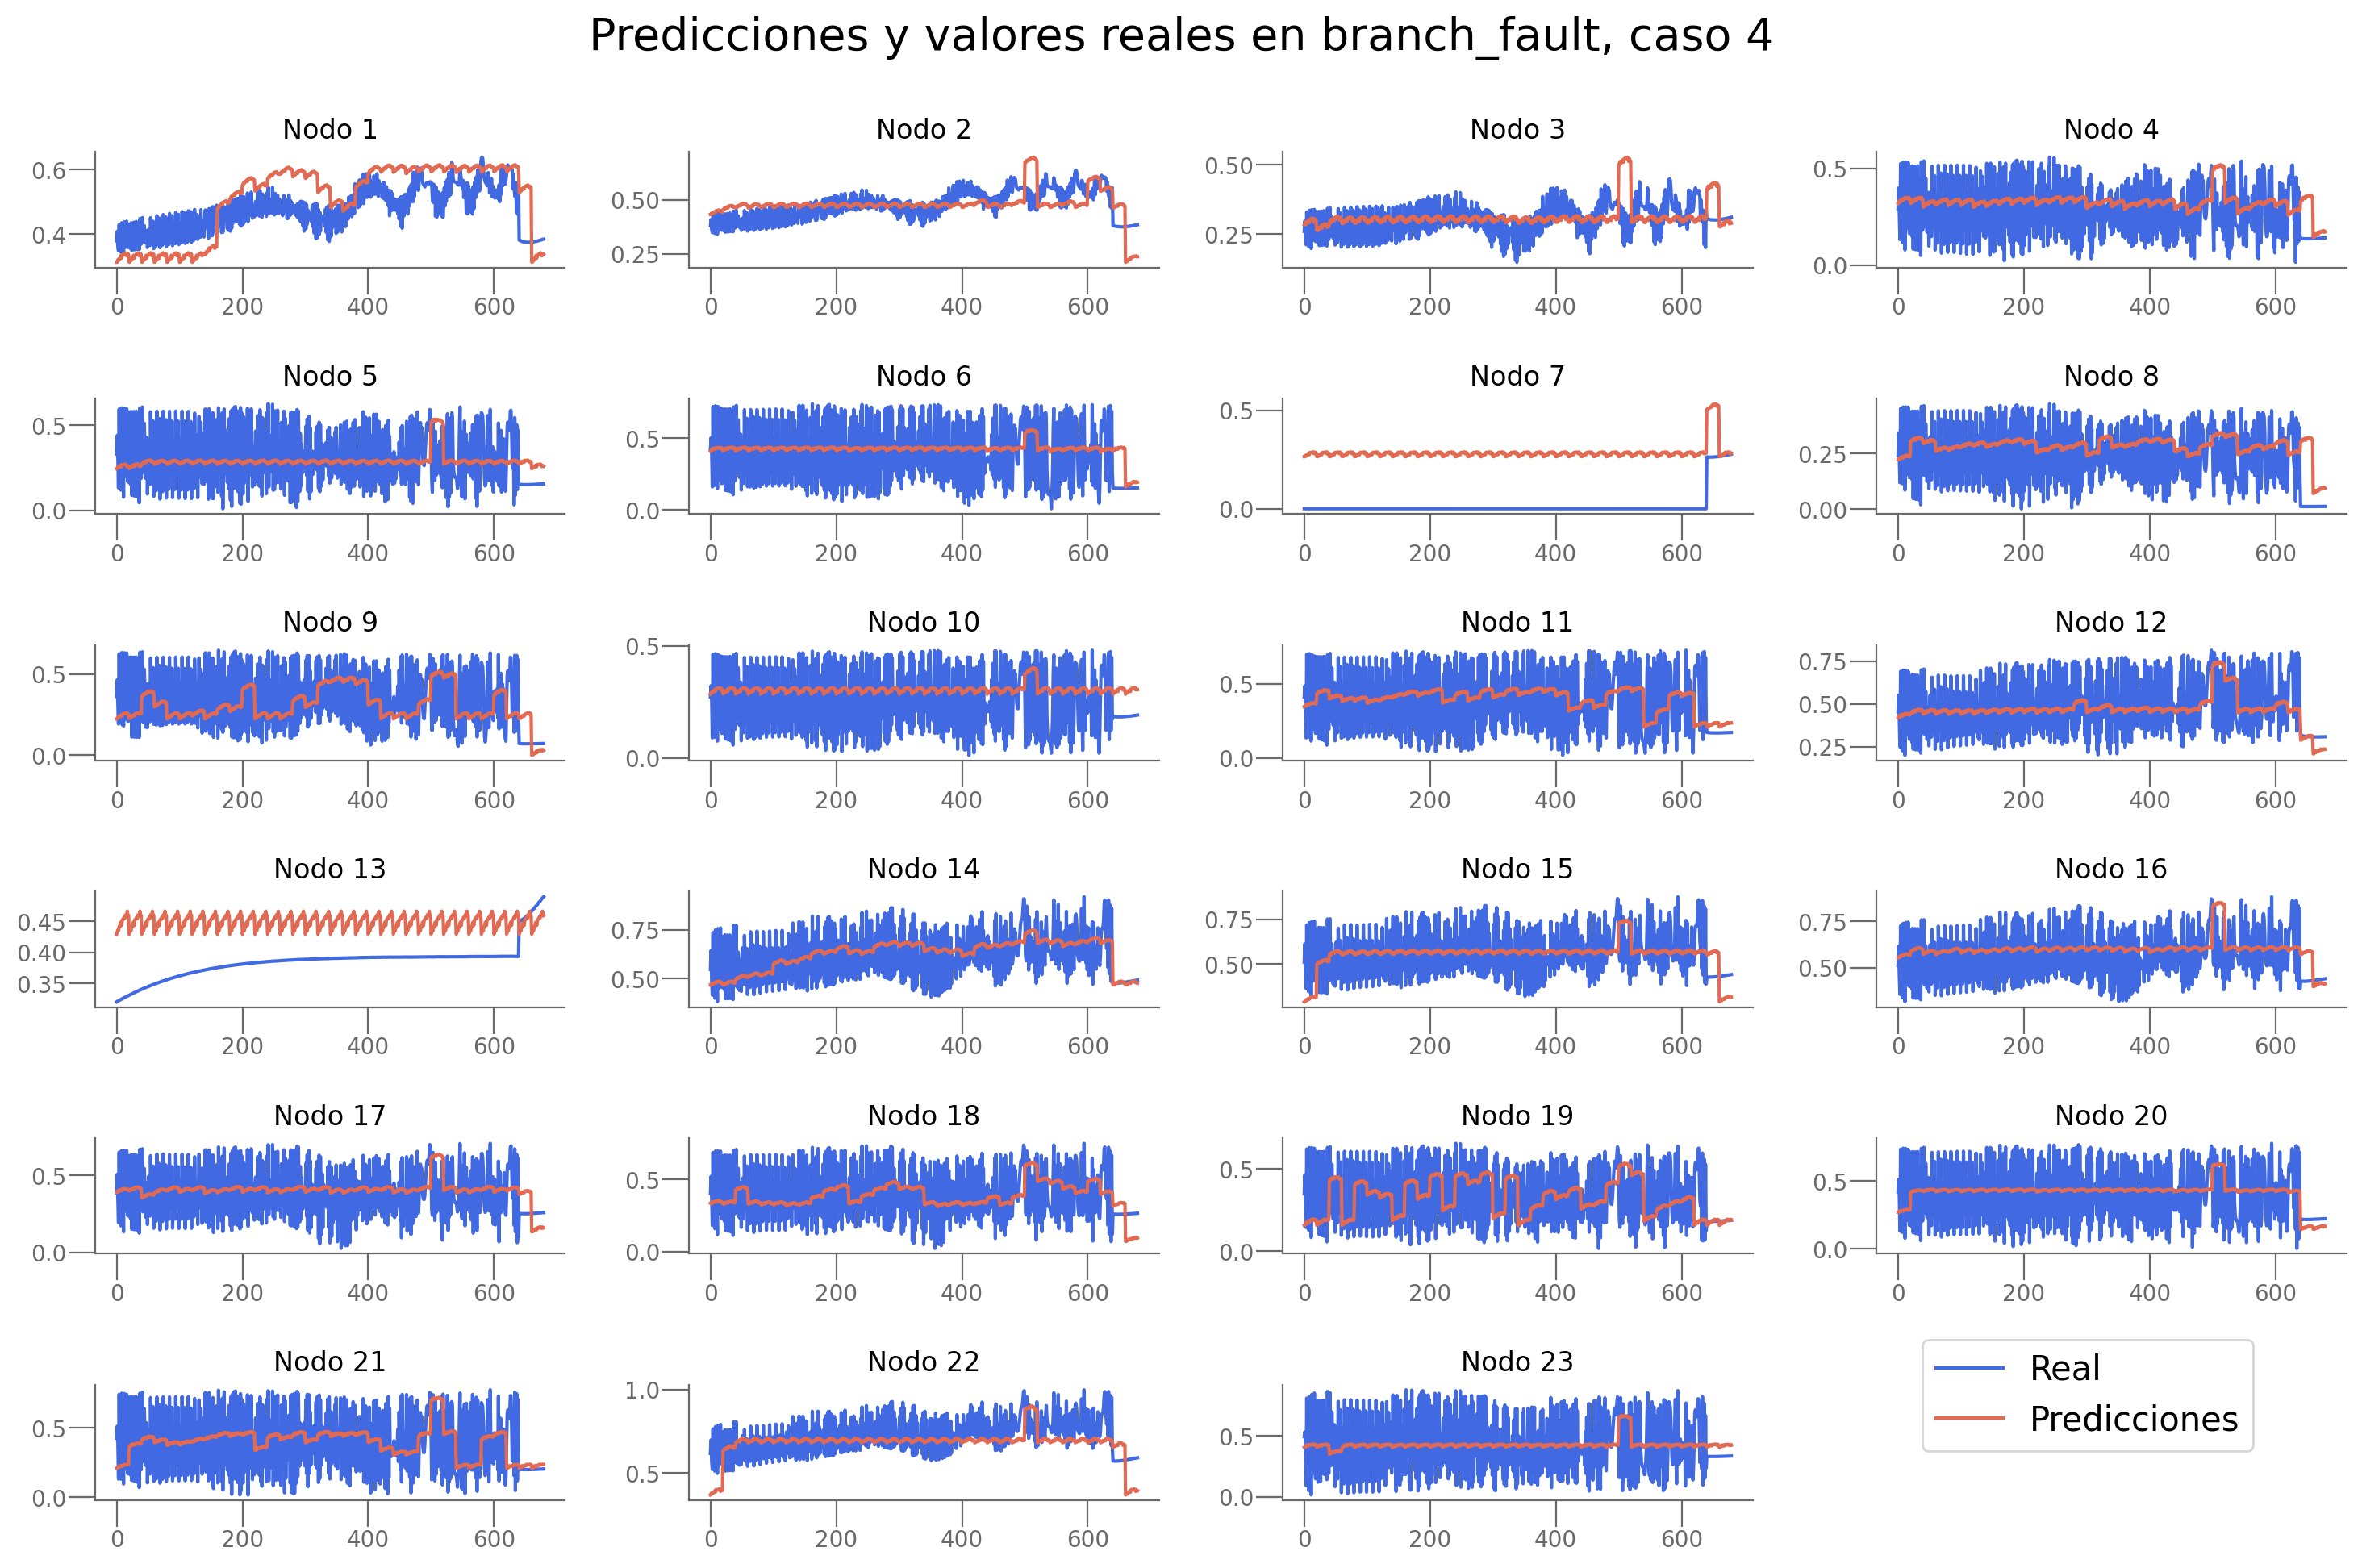

In [167]:
plot_predictions(predictions_brf, real_brf, n_target, 4,  n_div_brf, problem)

### Branch trip

In [168]:
problem = "branch_trip"
dataset_brt, situations_brt = loader.get_dataset( target= 20, intro=100, step=20, one_ts_per_situation=False, start = 1, type=problem)




Number of situations:  549
Number of timestamps:  800
Number of situations of the selected type:  101


In [70]:
n_div_brt = loader.div

#### Sencilla 

In [71]:
n_nodes =dataset_brt.features[0].shape[0]
n_target = dataset_brt.targets[0].shape[1]
n_features = dataset_brt[0].x.shape[1]
embedding_dim =5


==================== DATASET INFO ===================

Train dataset: 2715
Validation dataset: 345
Test dataset: 340

==================== DATALOADER INFO ===================

DataLoader for train set:
Number of batches: 543
DataLoader for val set:
Number of batches: 69
DataLoader for test set:
Number of batches: 68

==================== TRAIN INFO ===================

Epoch 1/30 | Train Loss: 0.0546 | Eval Loss: 0.0370 | Eval R2: -7.1188 | LR: 0.010000
Epoch 2/30 | Train Loss: 0.0385 | Eval Loss: 0.0313 | Eval R2: -5.9723 | LR: 0.010000
Epoch 3/30 | Train Loss: 0.0340 | Eval Loss: 0.0315 | Eval R2: -6.5288 | LR: 0.010000
Epoch 4/30 | Train Loss: 0.0301 | Eval Loss: 0.0246 | Eval R2: -4.8464 | LR: 0.010000
Epoch 5/30 | Train Loss: 0.0277 | Eval Loss: 0.0257 | Eval R2: -4.9161 | LR: 0.010000
Epoch 6/30 | Train Loss: 0.0270 | Eval Loss: 0.0225 | Eval R2: -4.4422 | LR: 0.010000
Epoch 7/30 | Train Loss: 0.0233 | Eval Loss: 0.0221 | Eval R2: -4.4059 | LR: 0.010000
Epoch 8/30 | Train Loss: 

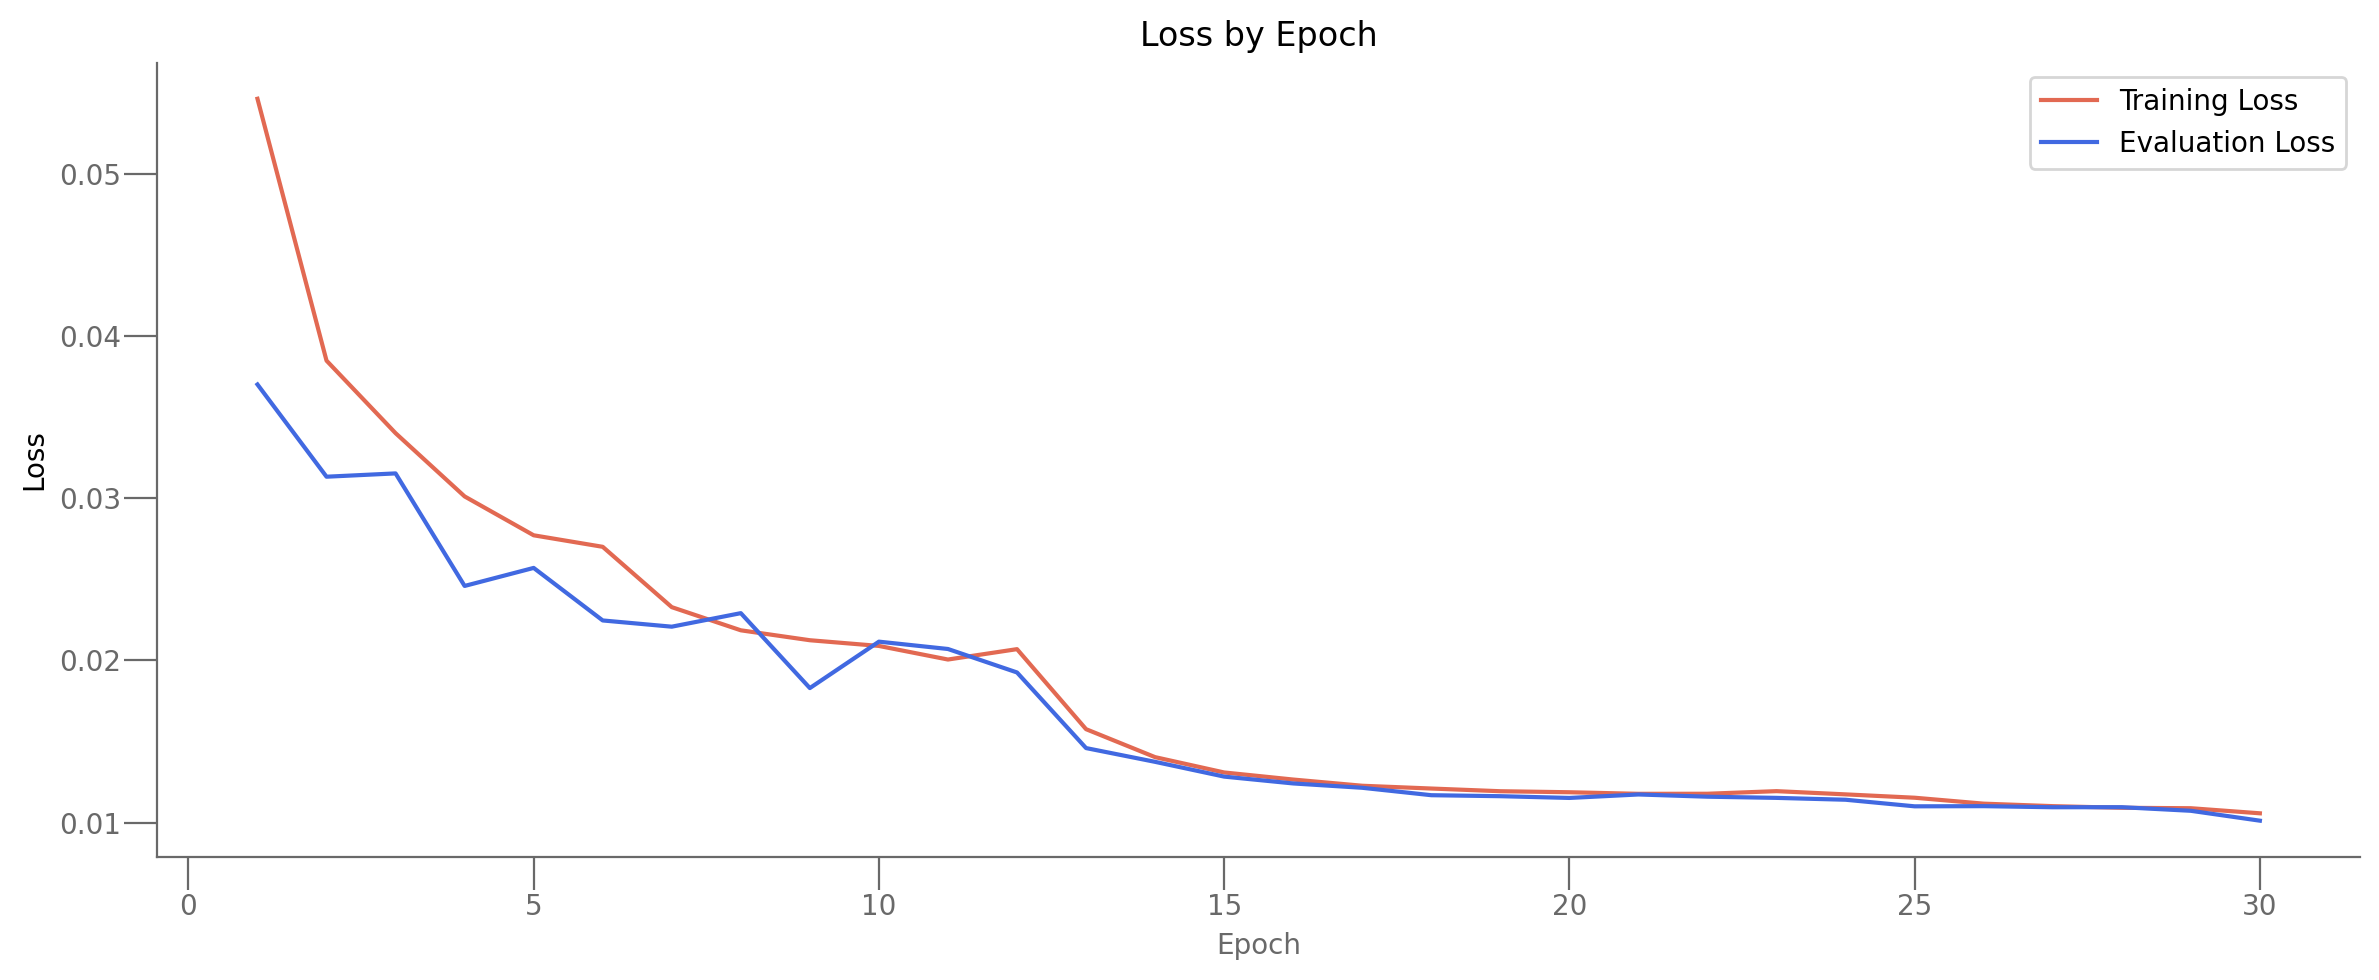


==================== TEST INFO ===================

Test_loss:0.0164, Test_r2:-0.9404


In [72]:
dataloader_params2 = {
            "batch_size": 5,
            "data_split_ratio": [0.7, 0.15, 0.15],
            "seed": 42,
            "keep_same": True
        }
dataloader_brt = trainer.train_test_val_split(dataset_brt, **dataloader_params2)


num_early_stop = 0
num_epochs = 30
lr = 0.01
model_brt = RecurrentGCN(n_features=n_features, n_nodes=n_nodes, embedding_dim=embedding_dim, n_target=n_target, name="RecurrentGCNInicial")
losses,eval_losses, r2scores, e, h = train(model_brt, dataloader_brt, num_early_stop, num_epochs, lr)
plot_training_and_eval_losses(np.array(losses).mean(axis=1), np.array(eval_losses).mean(axis=1), num_epochs, format_plot)
losses_tst, r2score_tst, predictions_brt, real_brt = test(model_brt, dataloader_brt, e, h)


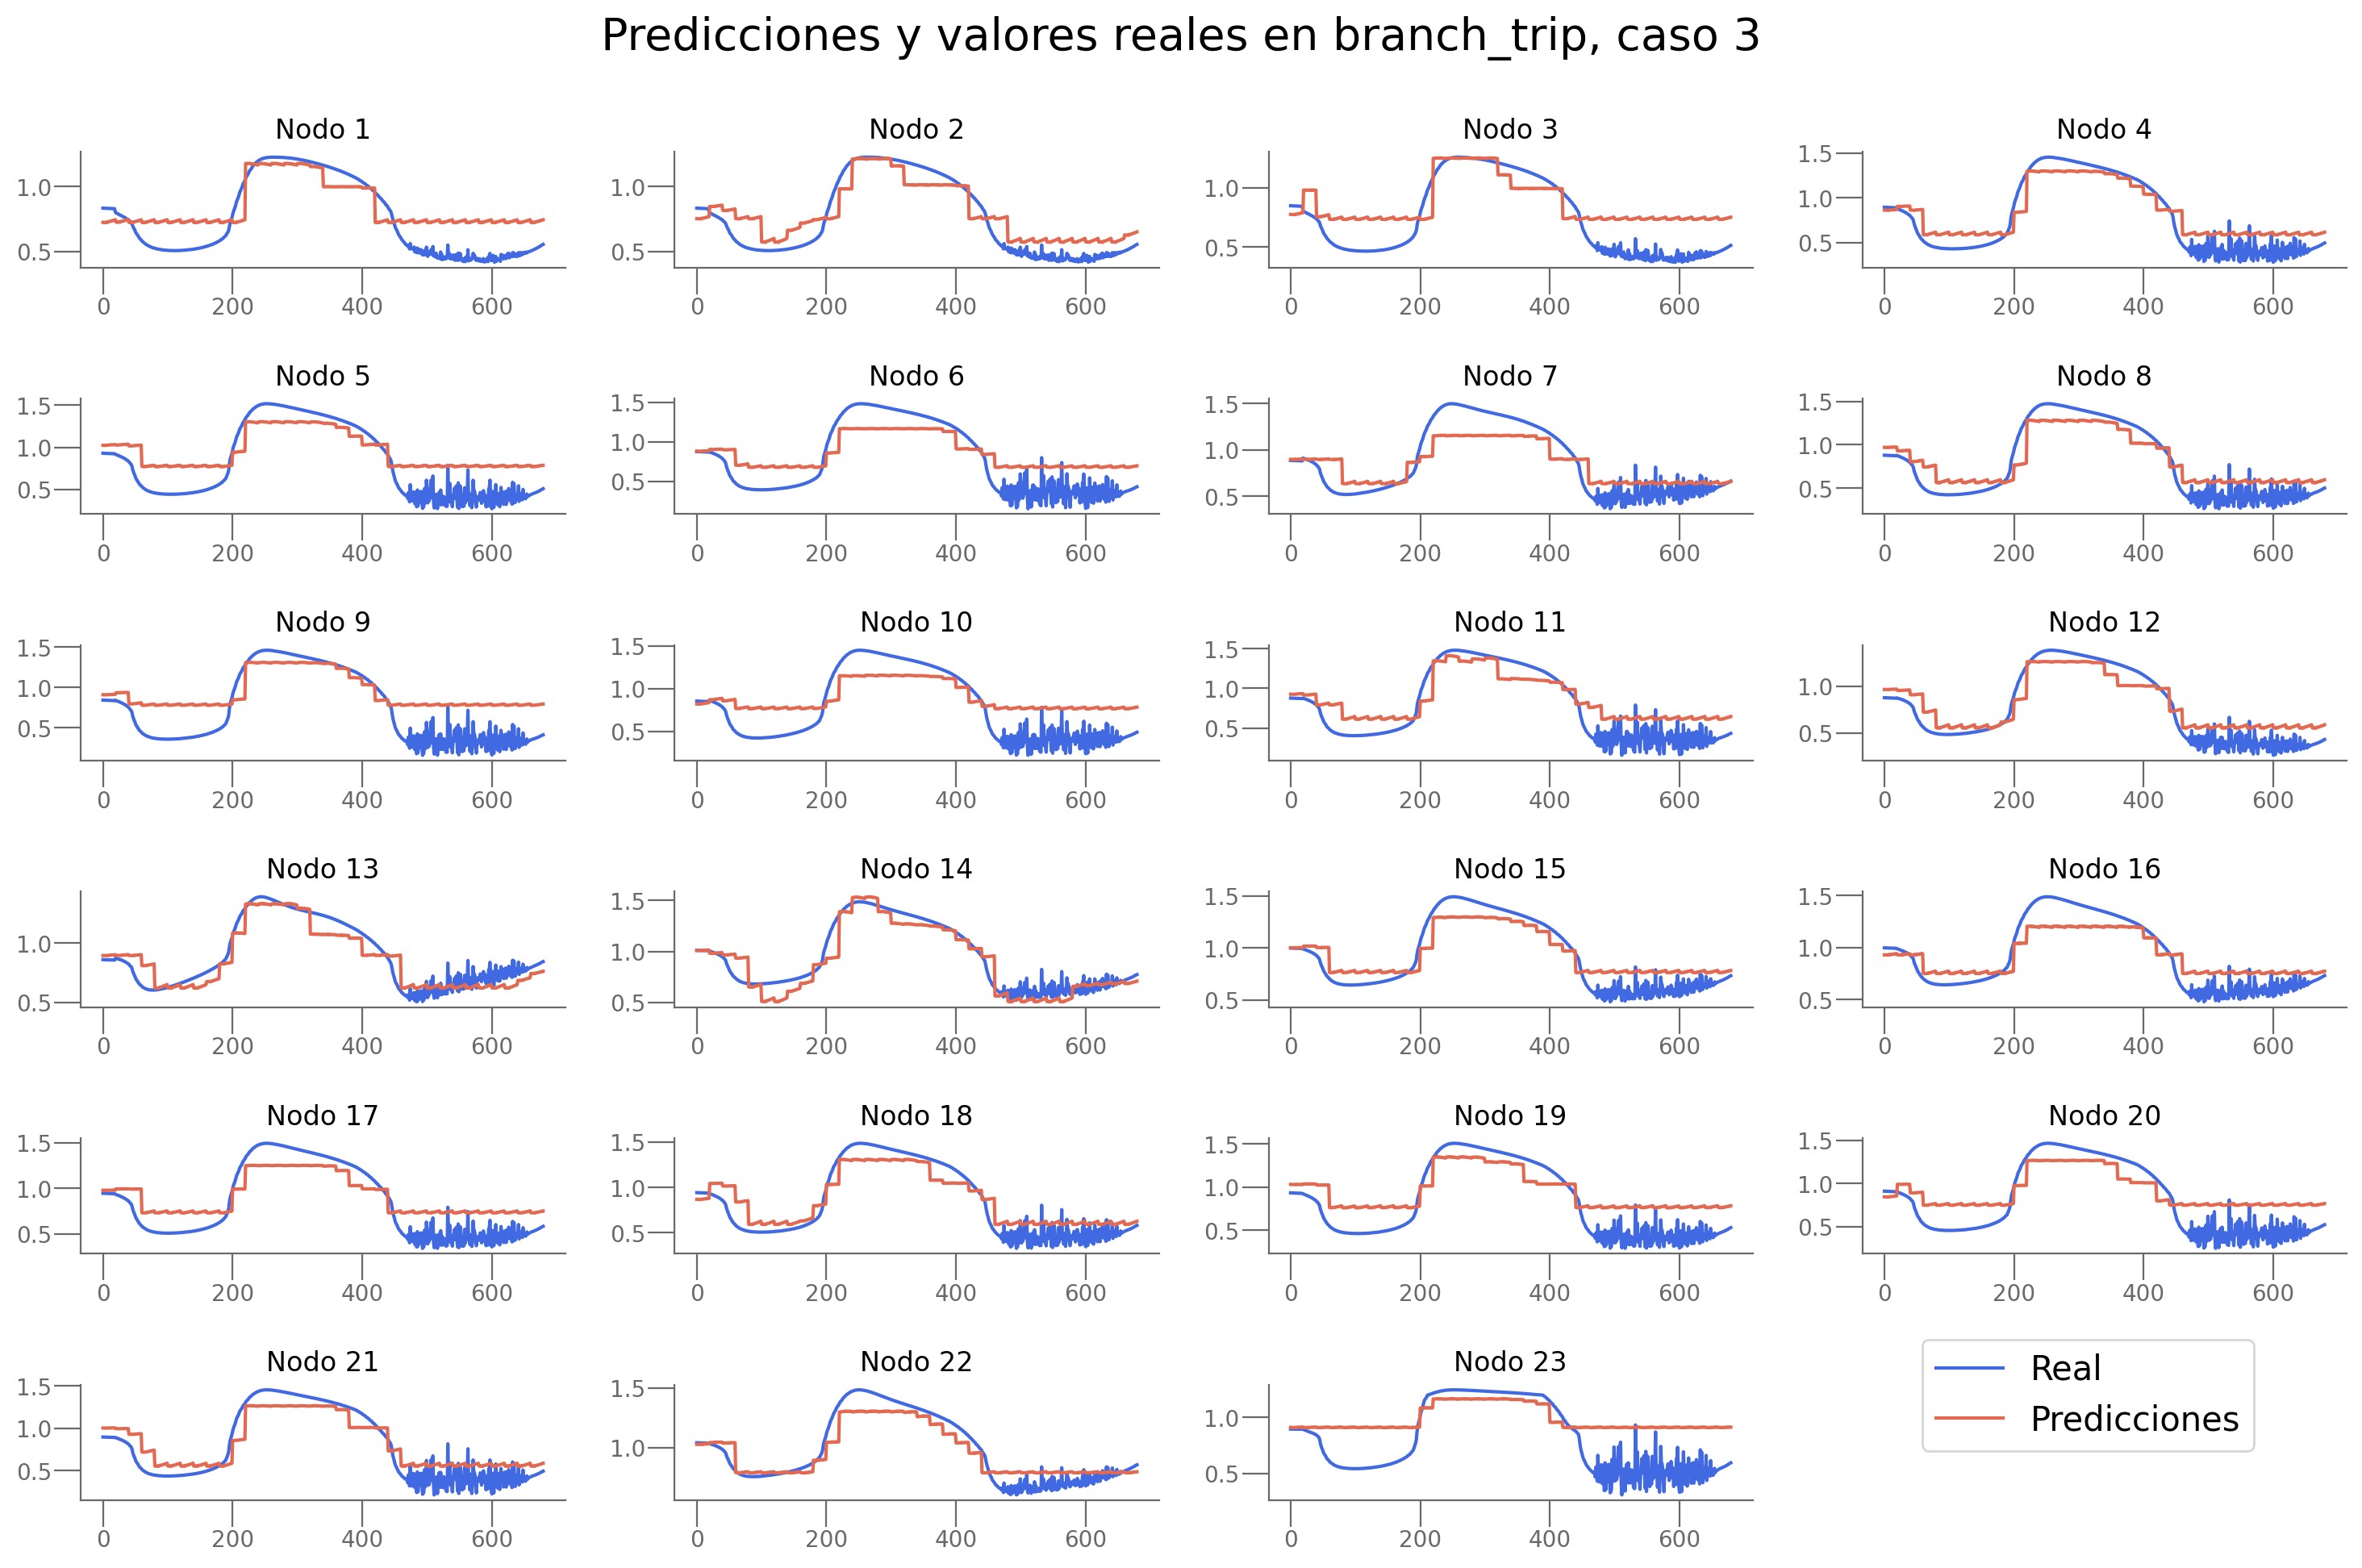

In [169]:
plot_predictions(predictions_brt, real_brt, n_target, 3, n_div_brt, problem)